In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.signal import stft 
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score
import statistics
import saxpy 
from IFEEL import ifeel_transformation, ifeel_extraction

from sklearn.metrics import davies_bouldin_score

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from skfuzzy.cluster import cmeans as FuzzyCMeans
from sklearn.mixture import GaussianMixture

import seaborn as sns


# from sklearn.preprocessing import StandardScaler
# from scipy.spatial.distance import cdist

Read Data

In [ ]:


# Define the folder path
folder_path = "Substation_Data/"

# Create an empty dictionary to store the dataframes
dataframes = {}

# Iterate through all files in the folder
for file_name in os.listdir(folder_path):
    # Check if the file is a CSV file
    if file_name.endswith(".csv"):
        # Extract the substation name from the file name
        substation_name = file_name.split(" ")[2:]
        substation_name = substation_name[:substation_name.index("POWER")]
        substation_name = " ".join(substation_name)
        
        # Read the CSV file into a pandas dataframe
        df = pd.read_csv(os.path.join(folder_path, file_name))
        # Convert date column to datetime -- using this as opportunity to skip over empty dataframes (if you don't want this, add "errors = 'ignore'" to the to_datetime command)
        try:
            df['Datetime'] = pd.to_datetime(df['Date (Dublin. Edinburgh. Lisbon. London)']) 
        except:
            continue
        # Drop old date column 
        df.drop('Date (Dublin. Edinburgh. Lisbon. London)', axis=1, inplace=True)
        # Add the dataframe to the dictionary with the substation ID as the key
        dataframes[substation_name] = df

# Print the dataframe keys to check that the IDs processed appropriately
print(dataframes.keys())


# 19/01/2023

### Feature extraction and analysis

In [ ]:
columns = ["mean", "max", "min", "std", 'median', 'var', 'sum']
dict_Features = {"Active Power [kW]": pd.DataFrame(columns=columns, index = dataframes.keys()),
               "Reactive Power [kVAr]": pd.DataFrame(columns=columns, index = dataframes.keys()),
               "Apparent Power [kVA]": pd.DataFrame(columns=columns, index = dataframes.keys()),
               "Power Factor": pd.DataFrame(columns=columns, index = dataframes.keys())}

# Loop through dictionary of substation dataframes
for substation, substation_df in dataframes.items():
    # Extract features
    for feature in dict_Features:
        dict_Features[feature].loc[substation] = substation_df[feature].describe().loc[['mean','max','min','std']]
        dict_Features[feature].loc[substation]['median'] = substation_df[feature].median()
        dict_Features[feature].loc[substation]['var'] = substation_df[feature].var()
        dict_Features[feature].loc[substation]['sum'] = substation_df[feature].sum()
        
dict_Features['Active Power [kW]'].head(5)
#dict_Features['Reactive Power [kVAr]'].head(5)
#dict_Features['Apparent Power [kVA]'].head(5)
#dict_Features['Power Factor'].head(5)

#### Active Power [kW]: Classify substations as based on amount of Active Power they are generating </br>


In [ ]:
# Define thresholds
high_kW_threshold = 50 # kW
medium_kW_threshold = 25 # kW

#Initialize empty lists
high_kW  = []
med_kW = []
low_kW = []

#Loop through dictionary of substation dataframes to categorize substations -- this example uses 'mean'
for key in dataframes.keys():
    if dict_Features['Active Power [kW]'].loc[key]['mean'] > high_kW_threshold:
        high_kW.append(key)
    elif dict_Features['Active Power [kW]'].loc[key]['mean'] > medium_kW_threshold:
        med_kW.append(key)
    else:
        low_kW.append(key)
        
#Check how many substations are in each list
print('High:', len(high_kW), '\n',
      'Med:', len(med_kW), '\n',
      'Low:', len(low_kW))

#### Reactive Power [kVAr]: Classify substations based on amount of Reactive Power they are generating </br>

In [ ]:
high_kVar_threshold = 1
medium_kVar_threshold = -1

high_kVAr  = []
med_kVAr = []
low_kVAr = []

for key in dataframes.keys():
    if dict_Features['Reactive Power [kVAr]'].loc[key]['mean'] > high_kVar_threshold:
        high_kVAr.append(key)
    elif dict_Features['Reactive Power [kVAr]'].loc[key]['mean'] > medium_kVar_threshold:
        med_kVAr.append(key)
    else:
        low_kVAr.append(key)
        
print('High:', len(high_kVAr), '\n',
      'Med:', len(med_kVAr), '\n',
      'Low:', len(low_kVAr))

#### Power Factor: Ratio of Apparent power to Active power (kVA/kW)) 


In [ ]:
high_PF_threshold = 0.95
medium_PF_threshold = 0.8

high_PF  = []
med_PF = []
low_PF = []

for key in dataframes.keys():
    if dict_Features['Power Factor'].loc[key]['mean'] > high_PF_threshold:
        high_PF.append(key)
    elif dict_Features['Power Factor'].loc[key]['mean'] > medium_PF_threshold:
        med_PF.append(key)
    else:
        low_PF.append(key)
        
print('High:', len(high_PF), '\n',
      'Med:', len(med_PF), '\n',
      'Low:', len(low_PF))

#### Look at substations that are high or low in both kW and kVAr 

In [ ]:
high_performance = []
low_performance = []
for key in dataframes.keys():
    if key in high_kW and key in high_kVAr:
        high_performance.append(key)
    if key in low_kW and key in low_kVAr:
        low_performance.append(key)
print('High performance substations', high_performance, '\n',
      'Low performance substations', low_performance)

Next steps:

Ientify leading, lagging, and unity substations: </br>
Leading - generating more reactive power than consuming </br>
Lagging - consuming more reactive power than generating </br>
Unity - generating and consuming same amount of reactive power 

Brainstorm further summary statistics with Elnaz

### Explore time usage

In [ ]:
'''
Given a dictionary of substation dataframes, returns a dictionary of the peak hour (kW) for each substation
'''
def extract_peak_hours(dataframes):
    # Create an empty dictionary to store the peak hour for each substation 

    
    for substation, substation_df in dataframes.items():
        
        # Group the data by hour
        hourly_data = substation_df.groupby(substation_df['Datetime'].dt.hour)['Active Power [kW]'].sum()

        # Normalize the data to get probability
        hourly_data = hourly_data / hourly_data.sum()
        
        # Store the peak hour for this substation in the dictionary 
        peak_hours[substation] = hourly_data[hourly_data == hourly_data.max()].index.tolist()
    
    return peak_hours

Plot histogram of peak hours

In [ ]:
peak_hours = extract_peak_hours(dataframes)
all_peak_hours = [item for sublist in peak_hours.values() for item in sublist]
plt.hist(all_peak_hours)
plt.xlabel("Hour of the day")
plt.ylabel("Frequency")
plt.title("Distribution of peak hours")
plt.show()




def extract_peak_hours_reactive

Average daily profile: Aggregate the load from all substations in each hour over the past month, and plot

In [ ]:
# List of features
features = ['Active Power [kW]', 'Reactive Power [kVAr]', 'Apparent Power [kVA]', 'Power Factor']


# Concatenate all dataframes into one
all_data = pd.concat(list(dataframes.values()))

# Extract the hour of the day from the datetime
all_data['hour'] = all_data['Datetime'].dt.hour

# Group the data by hour of the day
grouped_data = all_data.groupby('hour').mean()

# Plot the average daily load profile -- all features on one plot
grouped_data[features].plot()
plt.xlabel("Hour of the day")
plt.show()

# Create function to plot the average daily load profile for a single feature
def plot_power(dataframe, feature):
    plt.plot(dataframe[feature])
    plt.ylabel(feature)
    plt.xlabel("Hour of the day")
    plt.show()

#Plot features solo 
for feature in features:
    plot_power(grouped_data, feature)







# 21/01/2023

### Ratio analysis of daily load high and low periods



Ratio of peak/valley to average daily load (Active Power)

In [ ]:
'''
This function takes in a dictionary of substation dataframes and finds the ratio of the peak and valley hours to the average daily load (amplitudes)
'''
def extract_amplitudes(dataframes):
    #Dictionaries to store the peak and valley ratios for each substation
    peak_ratios = {}
    valley_ratios = {}
    
    for substation, substation_df in dataframes.items():
    
        # Group the data by hour
        hourly_data = substation_df.groupby(substation_df['Datetime'].dt.hour)['Active Power [kW]'].sum()

        # Get the ratio of the peak hour to the average daily load and store in the dictionary
        peak_ratios[substation] = hourly_data.max() / hourly_data.mean()
        
        # Get the ratio of the valley hour to the average daily load and store in the dictionary
        valley_ratios[substation] = hourly_data.min() / hourly_data.mean()
    
    return peak_ratios, valley_ratios

peak_ratios, valley_ratios = extract_amplitudes(dataframes)

#Plot the distribution of peak ratios
plt.hist(list(peak_ratios.values()))
plt.xlabel("Ratio of peak hour to average daily load")
plt.ylabel("Number of substations")
plt.show()

#Plot the distribution of valley ratios
plt.hist(list(valley_ratios.values()))
plt.xlabel("Ratio of valley hour to average daily load")
plt.ylabel("Number of substations")
plt.show()



         

How long Active Power > (1.5 * average daily load) per day </br>
How long Active Power < (0.75 * average daily load) per day 

In [ ]:
'''
This function takes in a dictionary of substation dataframes and finds:
on average how long the active power is more than 1.5 * average daily load
on average how long the active power is less than 0.75 * average daily load

NOTE: For whatever time frame we end up looking at, we may not want to compare the average of each hour to the average daily load, but rather the actual value in each hour over the entire time frame to avareage daily load, and then divide that by the number of days in the time period. Let me know. 
'''
def estimate_hot_or_cold(dataframes):
    #Dictionaries to store the peak and valley ratios for each substation
    hot_times = {}
    cold_times = {}
    
    for substation, substation_df in dataframes.items():
    
        # Group the data by hour
        hourly_data = substation_df.groupby(substation_df['Datetime'].dt.hour)['Active Power [kW]'].sum()
        
        # Get ratio of each hour to the mean
        hourly_data = hourly_data / hourly_data.mean()
        
        # Get the number of hours per day that the active power is more than 1.5 * average daily load
        hot_times[substation] = hourly_data[hourly_data > 1.5].count() 
        
        # Get the number of hours per day that the active power is less than 0.75 * average daily load
        cold_times[substation] = hourly_data[hourly_data < 0.75].count() 
    
    return hot_times, cold_times

hot_times, cold_times = estimate_hot_or_cold(dataframes)

#Plot the distribution of how many hours per day each substation is 'running hot' on average
plt.hist(list(hot_times.values()))
plt.xlabel("Number of hours above 1.5 * average daily load")
plt.ylabel("Number of substations")
plt.show()

#Plot the distribution of how many hours per day each substation is 'running cold' on average
plt.hist(list(cold_times.values()))
plt.xlabel("Number of hours below 0.75 * average daily load")
plt.ylabel("Number of substations")
plt.show()



### Smoothness of signal

Root mean square (RMS) deviation: </br>
Measure of average deviation of the signal from its mean value. 
Lower RMS = smoother, Higher RMS = more fluctuations.

Variance: Low variance = more consistent, and therefore smooth and flat signal 

Kurtosis: Signal with high kurtosis has heavy-tailed distribution and therefore greater fluctations than signal with low kurtosis

Short-Time Fourier Transform (STFT): Extract the frequency component of the signal, and the smoothness can be estimated by observing the frequency component. Using standard deviation of the fluctuation in active power, a signal with less fluctuation in frequency component is smoother. 

In [ ]:
'''
This function takes in a dictionary of substation dataframes and returns a dictionary of RMS deviation and variance for each substation
'''

def compute_smoothness_metrics(dataframes):
    #Dictionaries to store the peak and valley ratios for each substation
    rms = {}
    variance = {}
    kurtosis = {}
    stft_smoothness = {}
    
    for substation, substation_df in dataframes.items():
    
        # Root-mean square
        rms[substation] = np.sqrt(np.mean(substation_df['Active Power [kW]']**2))
    
        # Variance
        variance[substation] = np.var(substation_df['Active Power [kW]'])
        
        # Kurtosis
        kurtosis[substation] = substation_df['Active Power [kW]'].kurtosis()
        
        # Short Time Fourier Transform (STFT) 
        # Apply STFT to the active power signal (f = array of sample frequencies, t = array of segment times, Zxx is ndarray of STFT coefficients of Active Power signal)
        f,t, Zxx = stft(substation_df['Active Power [kW]'].values, fs=1, window='hann', nperseg=len(substation_df['Active Power [kW]'].values))

        # Calculate the average power of the STFT coefficients
        avg_power = np.mean(np.abs(Zxx) ** 2, axis=0)

        # Calculate the standard deviation of the average power
        std_dev = np.std(avg_power)
        
        stft_smoothness[substation] = std_dev

    return rms, variance, kurtosis, stft_smoothness

rms, var, kur, stft_smoothness = compute_smoothness_metrics(dataframes)


#Plot the distribution of RMS deviation for each substation
plt.hist(list(rms.values()))
plt.xlabel("RMS deviation of active power")
plt.ylabel("Frequency")    
plt.show() 

#Plot the distribution of Variance for each substation
plt.hist(list(var.values()))
plt.xlabel("Variance of active power")
plt.ylabel("Frequency")    
plt.show() 

#Plot the distribution of Kurtosis for each substation
plt.hist(list(kur.values()))
plt.xlabel("Kurtosis of active power")
plt.ylabel("Frequency")    
plt.show() 

#Plot the distribution of smoothness based on stft coefficient std dev for each substation
plt.hist(list(stft_smoothness.values()))
plt.xlabel("Smoothness")
plt.ylabel("Number of substations")

#Descriptive statistics of smoothness
print(pd.Series(stft_smoothness.values()).describe().apply(lambda x: format(x, 'f')))



### Boxplot of consumption per hour for each substation

In [ ]:
'''
This function takes in a dictionary of substation dataframes and plots a boxplot with hour of the day on the x-axis and active power (kW) on the y-axis for each substation
'''

def plot_hourly_consumption(substation_data):
    for substation, df in substation_data.items():
        # Extract the hour of the day from the timestamp
        df['hour'] = df['Datetime'].dt.hour
        
        # Create an empty list to store the data for each hour
        hourly_data = [[] for i in range(24)]
        # Add the active power (kW) data to the corresponding hour list
        for i, row in df.iterrows():
            hourly_data[row['hour']].append(row['Active Power [kW]'])

        # Create a box plot of the hourly data
        plt.boxplot(hourly_data,labels=range(24))
        plt.title(f'Hourly Consumption for Substation {substation}')
        plt.xlabel('Hour of the Day')
        plt.ylabel('Active Power (kW)')
        plt.show()
plot_hourly_consumption(dataframes)


### TODO: Distribution of peak hours for each substation separately </br>

For reactive power, separate substations based on positive / negative ones? 

### Clustering 

K-means: Clustering on Active Power and Reactive Power and Silhouette analysis to determine number of clusters

In [ ]:
features_of_interest

In [ ]:
# Define the number of clusters to test 
k_range = range(2, 20)


features_of_interest = []
for substation, substation_df in dataframes.items():
    # Extract features
    features_of_interest.append([substation_df['Active Power [kW]'].mean(),
              substation_df['Reactive Power [kVAr]'].mean()])

silhouette_scores = []
for k in k_range:
    # Perform K-means clustering
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(features_of_interest)
    
    # Calculate silhouette score for this k
    silhouette_scores.append(silhouette_score(features_of_interest, kmeans.labels_))

# Plot the silhouette scores
plt.plot(k_range, silhouette_scores)
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.show()

# Assign cluster labels to substations
substation_clusters = {}
for i, substation in enumerate(dataframes.keys()):
    substation_clusters[substation] = kmeans.labels_[i]

# Print the cluster assignments
print("Clusters based on Active and Reactive Power")
print(substation_clusters)
    

K-means: Clustering based on RMS, Variance, Kurtosis, and STFT Smoothness and Silhouette analysis to determine number of clusters

In [ ]:

def k_means(substation_dataframes, k_range):
    
    features_of_interest = []
    
    
    for substation, metric in substation_dataframes.items():
        # Extract features - there is only one value per dataframe for each of the smoothness metrics, so we can just use the entire object 
        features_of_interest.append([metric])

    all_substation_clusters = {}
    silhouette_scores = []
    for k in k_range:
        # Perform K-means clustering
        kmeans = KMeans(n_clusters = k)
        kmeans.fit(features_of_interest)
        
        # Calculate silhouette score for this k
        silhouette_scores.append(silhouette_score(features_of_interest, kmeans.labels_))

        # Assign cluster labels to substations
        substation_clusters = {}
        for i, substation in enumerate(substation_dataframes.keys()):
            substation_clusters[substation] = kmeans.labels_[i]

        # Save the cluster assignments 
        all_substation_clusters[k] = substation_clusters
        
    # Plot the silhouette scores
    plt.plot(k_range, silhouette_scores)
    plt.xlabel("k")
    plt.ylabel("Silhouette Score")
    plt.show()
    
    
    return all_substation_clusters

k_range = range(2,21)

print("RMS Clustering")
rms_clusters = k_means(rms, k_range)

print("Variance Clustering")
var_clusters =k_means(var, k_range)

print("Kurtosis Clustering")
kur_clusters =k_means(kur, k_range)

print("STFT Clustering")
stft_clusters =k_means(stft_smoothness, k_range)





Comparing cluster outputs

In [ ]:
# NOTE: This approach assumes the keys are in the same order for all dictionaries (which I think actually works here, since even though the are hashed it was run the same way and it gives the same answers every time it is run)

# TODO: Save these values in a dictionary and compare between k's 

for k in k_range:
    print("k = ", k)
    
    # Compare count and percentage of matching cluster assignments between RMS and Variance
    print("# matching between RMS and Var:", sum(a == b for a,b in zip(rms_clusters[k].values(), var_clusters[k].values())))
    print("% matching between RMS and Var:", round(sum(a == b for a,b in zip(rms_clusters[k].values(), var_clusters[k].values())) / len(var_clusters[k].values()), 3))

    # Compare count and percentage of matching cluster assignments between all lists
    print("# matching between all lists:", sum(a == b and b == c and c == d for a,b,c,d in zip(rms_clusters[k].values(), var_clusters[k].values(), kur_clusters[k].values(), stft_clusters[k].values())))
    print("# matching between all lists:", round(sum(a == b and b == c and c == d for a,b,c,d in zip(rms_clusters[k].values(), var_clusters[k].values(), kur_clusters[k].values(), stft_clusters[k].values())) / len(var_clusters[k].values()), 3))
    
    print("\n")



### Plot substations on a map

In [ ]:
# get location data 

Next steps:
Analyze the substations that are outliers on the peak hours histogram

# 25/01/2023

Goal: Identify weird substations

### Distribution of peak hours for each substation separately 



Active / Reactive Power

In [ ]:
def plot_peak_hour_distributions(dataframes, active):
    for substation, substation_data in dataframes.items():
        substation_data['Date'] = substation_data['Datetime'].dt.date
        substation_data['Hour'] = substation_data['Datetime'].dt.hour
        
        # Group the data by date
        daily_groups = substation_data.groupby(['Date'])

        if active:
        # Find the hour of peak Active Power for each date 
            peak_hour = daily_groups['Active Power [kW]'].idxmax().map(lambda x: substation_data.loc[x, 'Hour'])
                        # Count the number of times each hour appears as the peak hour for each day
            peak_counts = peak_hour.value_counts()
            
            plt.bar(peak_counts.index, peak_counts.values)
            plt.xlabel('Hour of the day')
            plt.ylabel('Frequency of being peak hour')
            plt.title(f'Peak Hour Distribution for {substation}')
            plt.savefig(f'peak_hr_histograms/peak_hour_distribution_{substation}.png')
            plt.show()
            
        else:
                # Find the hour of peak positive and negative Reactive power for each day
            peak_hour_max = daily_groups['Reactive Power [kVAr]'].idxmax().map(lambda x: substation_data.loc[x, 'Hour'])
            peak_hour_min = daily_groups['Reactive Power [kVAr]'].idxmin().map(lambda x: substation_data.loc[x, 'Hour'])
            
                # Count the number of times each hour appears as the peak hour for each day
            peak_counts_max = peak_hour_max.value_counts()
            peak_counts_min = peak_hour_min.value_counts()
            
            plt.bar(peak_counts_max.index, peak_counts_max.values)
            plt.xlabel('Hour of the day')
            plt.ylabel('Frequency of being peak hour')
            plt.title(f'Positive Reactive Power Peak Hour Distribution for {substation}')
            plt.show()
            plt.bar(peak_counts_min.index, peak_counts_min.values)
            plt.xlabel('Hour of the day')
            plt.ylabel('Frequency of being peak hour')
            plt.title(f'Negative Reactive Power Peak Hour Distribution for {substation}')
            plt.show()



Reactive Power

In [ ]:
for substation, substation_data in dataframes.items():
    substation_data['Date'] = substation_data['Datetime'].dt.date
    substation_data['Hour'] = substation_data['Datetime'].dt.hour
    
    # Group the data by date
    daily_groups = substation_data.groupby(['Date'])

    # Find the hour of peak positive and negative Reactive power for each day
    peak_hour_max = daily_groups['Reactive Power [kVAr]'].idxmax().map(lambda x: substation_data.loc[x, 'Hour'])
    peak_hour_min = daily_groups['Reactive Power [kVAr]'].idxmin().map(lambda x: substation_data.loc[x, 'Hour'])
    
    # Count the number of times each hour appears as the peak hour for each day
    peak_counts_max = peak_hour_max.value_counts()
    peak_counts_min = peak_hour_min.value_counts()
    
    plt.bar(peak_counts_max.index, peak_counts_max.values)
    plt.xlabel('Hour of the day')
    plt.ylabel('Frequency of being peak hour')
    plt.title(f'Positive Reactive Power Peak Hour Distribution for {substation}')
    plt.show()
    plt.bar(peak_counts_min.index, peak_counts_min.values)
    plt.xlabel('Hour of the day')
    plt.ylabel('Frequency of being peak hour')
    plt.title(f'Negative Reactive Power Peak Hour Distribution for {substation}')
    plt.show()

# <font color ='orange'> Year-long Substation Data (Jan 1 2022 - Jan 1 - 2023) </font>

### <font color='lightgreen'> Read Data </font>

Feeder level

In [ ]:

# Define the folder path
folder_path = "Yearly Substation Data/"

# Create an empty dictionary to store the dataframes
dataframes = {}

# Iterate through all files in the folder
for file_name in os.listdir(folder_path):
    # Check if the file is a CSV file
    if file_name.endswith(".csv"):
        # Extract the substation name from the file name
        substation_name = file_name.split(" ")[2:]
        substation_name = substation_name[:substation_name.index("POWER")]
        substation_name = " ".join(substation_name)
        
        # Read the CSV file into a pandas dataframe
        df = pd.read_csv(os.path.join(folder_path, file_name))
        # Convert date column to datetime -- using this as opportunity to skip over empty dataframes (if you don't want this, add "errors = 'ignore'" to the to_datetime command)
        try:
            df['Datetime'] = pd.to_datetime(df['Date (Dublin. Edinburgh. Lisbon. London)']) 
        except:
            continue
        # Drop old date column 
        df.drop('Date (Dublin. Edinburgh. Lisbon. London)', axis=1, inplace=True)
        # Add the dataframe to the dictionary with the substation ID as the key
        dataframes[substation_name] = df

# Print the dataframe keys to check that the IDs processed appropriately
print(dataframes.keys())


Busbar level

In [ ]:

# Define the folder path
folder_path = "Substation Busbar Data/"

# Create an empty dictionary to store the dataframes
dataframes = {}

# Iterate through all files in the folder
for file_name in os.listdir(folder_path):
    # Check if the file is a CSV file
    if file_name.endswith(".csv"):
        print(file_name, '\n')
        # Extract the substation name from the file name
        substation_name = file_name.split(" ")[2:]
        substation_name = substation_name[:substation_name.index("POWER")]
        substation_name = " ".join(substation_name)
        
        # Read the CSV file into a pandas dataframe
        df = pd.read_csv(os.path.join(folder_path, file_name))
        # Convert date column to datetime -- using this as opportunity to skip over empty dataframes (if you don't want this, add "errors = 'ignore'" to the to_datetime command)
        try:
            df['Datetime'] = pd.to_datetime(df['Date (Dublin. Edinburgh. Lisbon. London)']) 
        except:
            continue
        # Drop old date column 
        df.drop('Date (Dublin. Edinburgh. Lisbon. London)', axis=1, inplace=True)
        # Add the dataframe to the dictionary with the substation ID as the key
        dataframes[substation_name] = df

# Print the dataframe keys to check that the IDs processed appropriately
print(dataframes.keys())


## Data Pre-Processing

### <font color='lightgreen'> Data cleaning: Handle Missing Values </font>

In [ ]:
############################################################
######Check for dataframes with missing values
############################################################
empty_substations = []
for substation, df in dataframes.items():
    if df.isna().sum().sum() > 0:
        empty_substations.append(substation)

if not empty_substations:
    print("No missing values")


# ############################################################
# ###### Drop substations with no active power data ###### ######  TODO: Get rid of this, it's covered by the below
# ############################################################ 
# empty_substations = []
# for substation, df in dataframes.items():
#     if abs(df['Active Power [kW]']).sum() == 0 or abs(df['Reactive Power [kVAr]']).sum() == 0:
#         empty_substations.append(substation)
        
# # Drop substations without any active power data (Heny Road T2 and Edinburgh Drive 1)
# for substation in empty_substations:
#     print(f"Substation {substation} has no active power data. Dropping from dataframe.")
#     del dataframes[substation]
    


########################################################################
### Drop substations with less than 50% available active power data ####
########################################################################
threshold = 0.50 # 50% threshold
substations_below_threshold = []
for substation, df in dataframes.items():
    count_zero = (df['Active Power [kW]'] == 0).sum()
    if count_zero > (len(df) * threshold):
        substations_below_threshold.append(substation)
        
for substation in substations_below_threshold:
    print(f"Substation {substation} has less than 50% available active power data. Dropping from dataframe.")
    del dataframes[substation]


# No missing values
# Substation Thames view Road no2 has less than 50% available active power data. Dropping from dataframe.
# Substation henry road T2 has less than 50% available active power data. Dropping from dataframe.
# Substation the perch binsey has less than 50% available active power data. Dropping from dataframe.
# Substation edinburgh drive 1 has less than 50% available active power data. Dropping from dataframe.
    
        

For all substations, drop days with any missing data
Missing data is defined as observations where active power is 0</BR>
<font color = 'pink'> DON'T RUN - NOT NEEDED ANYMORE </font>

In [ ]:
# '''
# This function takes in a dict of substation dataframes, and for each substation drops all days of data where 0 active power is observed. 
# The assumption is that 0 active power should never happen so this is a good way to remove days where the data is missing.
# '''
# def remove_days_with_missing_data(dataframes):
#     for substation, df in dataframes.items():
#         # Get the dates of days with 0 active power
#         df['Date'] = df['Datetime'].dt.date
#         zero_dates = df[df['Active Power [kW]'] == 0]['Date'].unique()
#         # Drop those dates from the dataframe
#         dataframes[substation] = df[~df['Date'].isin(zero_dates)]  
        
#     return dataframes
        
# dataframes = remove_days_with_missing_data(dataframes)



### <font color='lightgreen'> Data transformation: by season and time of week </font> 

Split by season

In [ ]:
def split_by_season(df):
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df['Month'] = df['Datetime'].dt.month
    
    spring = df[(df['Month'] >= 3) & (df['Month'] <= 5)]
    summer = df[(df['Month'] >= 6) & (df['Month'] <= 8)]
    fall = df[(df['Month'] >= 9) & (df['Month'] <= 11)]
    winter = df[(df['Month'] == 12) | ((df['Month'] >= 1) & (df['Month'] <= 2))]
    
    return spring, summer, fall, winter

substation_dataframes = {}
for substation, df in dataframes.items():
    spring, summer, fall, winter = split_by_season(df)
    substation_dataframes[substation] = {'spring': spring, 'summer': summer, 'fall': fall, 'winter': winter}



Split the season dataframes by time of week

In [ ]:
# Split seasonal dataframes into week and week-end dataframes
def split_weekend_week(df):
    df['weekday'] = df['Datetime'].dt.weekday
    week_df = df[df['weekday'].isin([0,1,2,3,4])]
    weekend_df = df[df['weekday'].isin([5,6])]
    return week_df, weekend_df

chopped_substation_dfs = {}
for substation, season_dict in substation_dataframes.items():
    chopped_substation_dfs[substation] = {}
    for season, df in season_dict.items():
        week_df, weekend_df = split_weekend_week(df)
        chopped_substation_dfs[substation][season] = {}
        chopped_substation_dfs[substation][season]['week'] = week_df
        chopped_substation_dfs[substation][season]['weekend'] = weekend_df
        

### <font color ='lightgreen'> Data cleaning: Drop the substations with not enough data in given season/time-of-week subset </font>

In [ ]:
# Drop substations with not enough data in sub-set
drop_list = []
for substation, seasons in chopped_substation_dfs.items():
    for season, days in seasons.items():
        for time_of_week, df in days.items():
            days_with_data = len(df['Datetime'].dt.date.unique())
            if time_of_week == 'week':
                if days_with_data < 33: # 33 days is ~1/2 of the 65 days in a season during the week 
                    print(f"Substation {substation} has only {days_with_data} days of data in {season} {time_of_week} (<~1/2 of what should be there). Dropping from analysis.")
                    drop_list.append(str(substation) + "_" + str(season) + "_" + str(time_of_week))
            else:
                if days_with_data < 13: #(has less than half of weekends)
                    print(f'Substation {substation} has only {days_with_data} days of data in {season} {time_of_week} (<~1/2 of what should be there). Dropping from analysis.')
                    drop_list.append(str(substation) + "_" + str(season) + "_" + str(time_of_week))
           # print(substation, season, time_of_week, len(df))

<font color='lightgreen'> Drop the underfull substation/season/time of week combinations </font>

In [ ]:
print("number of sub-datasets to drop,", len(drop_list))
for to_drop in drop_list:
    substation = to_drop.split("_")[0]
    season = to_drop.split("_")[1]
    time_of_week = to_drop.split("_")[2]
    del chopped_substation_dfs[substation][season][time_of_week]


### <font color='lightgreen'> Data cleaning: Detect Outliers </font> 

Plot histograms

In [ ]:
def plot_peak_hour_distributions(dataframes, active):
    for substation, substation_data in dataframes.items():
        substation_data['Date'] = substation_data['Datetime'].dt.date
        substation_data['Hour'] = substation_data['Datetime'].dt.hour
        
        # Group the data by date
        daily_groups = substation_data.groupby(['Date'])

        if active:
        # Find the hour of peak Active Power for each date 
            peak_hour = daily_groups['Active Power [kW]'].idxmax().map(lambda x: substation_data.loc[x, 'Hour'])
                        # Count the number of times each hour appears as the peak hour for each day
            peak_counts = peak_hour.value_counts()
            
            plt.bar(peak_counts.index, peak_counts.values)
            plt.xlabel('Hour of the day')
            plt.ylabel('Frequency of being peak hour')
            plt.title(f'Peak Hour Distribution for {substation}')
            plt.savefig(f'peak_hr_histograms/peak_hour_distribution_{substation}.png')
            plt.show()
            
        else:
                # Find the hour of peak positive and negative Reactive power for each day
            peak_hour_max = daily_groups['Reactive Power [kVAr]'].idxmax().map(lambda x: substation_data.loc[x, 'Hour'])
            peak_hour_min = daily_groups['Reactive Power [kVAr]'].idxmin().map(lambda x: substation_data.loc[x, 'Hour'])
            
                # Count the number of times each hour appears as the peak hour for each day
            peak_counts_max = peak_hour_max.value_counts()
            peak_counts_min = peak_hour_min.value_counts()
            
            plt.bar(peak_counts_max.index, peak_counts_max.values)
            plt.xlabel('Hour of the day')
            plt.ylabel('Frequency of being peak hour')
            plt.title(f'Positive Reactive Power Peak Hour Distribution for {substation}')
            plt.show()
            plt.bar(peak_counts_min.index, peak_counts_min.values)
            plt.xlabel('Hour of the day')
            plt.ylabel('Frequency of being peak hour')
            plt.title(f'Negative Reactive Power Peak Hour Distribution for {substation}')
            plt.show()



In [ ]:
plot_peak_hour_distributions(dataframes, active = True)

## <font color = 'orange'> Data Imputation?? 

Compute median daily load curve for each day of the week for each substation in the dataset, and fill missing days with corresponding curve?
Or leave missing days out </font>

## <font color = 'orange'> Feature Extraction <font>

### <font color ='lightgreen'> Extract features for clustering (functions) </font>

Global features  </br>

Mean value of daily load pattern </br>
SD of daily load pattern </br>
Max power consumption during a day  </br>
Min power consumption during a day  </br>
Range power consumption during a day (max - min) </br>
Perc values above mean val  </br>
Sum of net loads during business hours (9am-6pm) </br>
Sum of net loads during non-business hours </br>
Skewness of the distribution of a daily load pattern  </br>
Kurtosis of distribution of a daily load pattern  </br>
Mode of 5-bin histogram for daily load pattern   </br>
Longest sub-sequence where consecutive value above mean value  </br>
Longest period of successive increase  </br>

1.<font color ='pink'> Get as statistical features for the distribution of total daily loads across the year  _DEPRECATED_ <font> </br>


In [ ]:
'''
This function (v1) extracts the global features for a distribution of total daily loads within the measured dataset for each substation
'''

def extract_global_features(df):
    # convert datetime column to datetime type
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    
    df['Date'] = df['Datetime'].dt.date
    df['Hour'] = df['Datetime'].dt.hour
    
    # set datetime column as index
    df = df.set_index('Datetime')
    
    # group data by day to get daily load pattern (total energy consumed in a day)
    daily_loads = df.resample('D').sum()
    
    # Mean daily power consumption 
    mean_daily_load_pattern = daily_loads['Active Power [kW]'].mean()
    
    # Std deviation of daily power consumption
    sd_daily_load_pattern = daily_loads['Active Power [kW]'].std()
    
    # Max power consumption during a day
    max_power_consumption = daily_loads['Active Power [kW]'].max()
    
    # Min power consumption during a day
    min_power_consumption = daily_loads['Active Power [kW]'].min()
    
    # Range of power consumption during a day
    range_power_consumption = max_power_consumption - min_power_consumption

    # Maximum within-day power consumption range 
    (daily_groups['Active Power [kW]'].max() - daily_groups['Active Power [kW]'].min()).max()
    
    # Percent values above mean value
    percent_values_above_mean = (daily_loads > mean_daily_load_pattern).mean() * 100
    
    # Sum of net loads during business hours (9am-6pm)
    business_hours = (df.index.hour >= 9) & (df.index.hour < 18)
    sum_net_loads_business_hours = df[business_hours].sum()
    
    # Sum of net loads during non-business hours
    non_business_hours = ~business_hours
    sum_net_loads_non_business_hours = df[non_business_hours].sum()
    
    # kewness of the distribution of a daily load pattern
    skewness_daily_load_pattern = daily_loads.skew()
    
    # kurtosis of distribution of a daily load pattern
    kurtosis_daily_load_pattern = daily_loads.kurtosis()
    
    # mode of 5-bin histogram for daily load pattern
    hist, bin_edges = np.histogram(daily_loads, bins=5)
    mode_5_bin_histogram = bin_edges[np.argmax(hist)]
    
    # longest sub-sequence where consecutive value above mean value
    # above_mean = daily_load_pattern > mean_daily_load_pattern
    # longest_subseq_above_mean = above_mean.astype(int).diff().ne(0).cumsum()
    # group = longest_subseq_above_mean.groupby(longest_subseq_above_mean).cumcount()
    # longest_subseq_above_mean = (group + 1).max()
    
    # longest sub-sequence where consecutive value above mean value
   # longest_subseq_above_mean = ((daily_load_pattern > mean_daily_load_pattern).astype(int)
                       #           .groupby((~daily_load_pattern.astype(int)).cumsum()).sum().max())

    # longest period of successive increases
    # increase = (daily_load_pattern.diff() > 0).astype(int)
    # longest_period_successive_increases = increase.astype(int).diff().ne(0).cumsum()
    # group = longest_period_successive_increases.groupby(longest_period_successive_increases).cumcount()
    # longest_period_successive_increases = (group + 1).max()
    
    features = {
        'Mean value of daily load pattern (kW)': mean_daily_load_pattern,
        'SD of daily load pattern (kW)': sd_daily_load_pattern,
        'Max power consumption during a day (kW)': max_power_consumption,
        'Min power consumption during a day (kW)': min_power_consumption,
        'Range of power consumption during a day (max - min) (kW)': range_power_consumption,
        'Percent values above mean val (%)': percent_values_above_mean,
        'Sum of net loads during business hours (9am-6pm)': sum_net_loads_business_hours,
        'Sum of net loads during non-business hours': sum_net_loads_non_business_hours,
        'Skewness of the distribution of a daily load pattern': skewness_daily_load_pattern,
        'Kurtosis of distribution of a daily load pattern': kurtosis_daily_load_pattern,
        'Mode of 5-bin histogram for daily load pattern': mode_5_bin_histogram
        #'Longest sub-sequence where consecutive value above mean value': longest_subseq_above_mean,
       # 'Longest period of successive increases': longest_period_successive_increases
    }
    
    return pd.DataFrame(features, index=[0])

# extract features for all dataframes
all_features = []
for substation, df in dataframes.items():
    features = extract_global_features(df)
    features['Substation'] = substation
    all_features.append(features)
    
# concatenate all features into one dataframe
all_features_concat = pd.concat(all_features)



<font color='pink'> _DEPRECATED function_

2. Get as average of the values of these statistical features for each daily load in the year (i.e. for statistical feature i in I SUM(i,d=1...365)SF_n,i/365))  [so here the distribution is the distribution of values that each feature takes across the whole year].  </font>

In [ ]:
'''
This function (v2) gets a distribution statistical features for each daily load in dataset, and returns them in a dictionary where each key is a feature and each value is a series containing that feature's distribution for each day in the dataset.
'''

def extract_global_features_v2(substation, df):
    # convert datetime column to datetime type
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    
    df['Date'] = df['Datetime'].dt.date
    df['Hour'] = df['Datetime'].dt.hour
    
    # set datetime column as index
    df = df.set_index('Datetime')
    
    # group data by day to get daily load pattern (total energy consumed in a day)
   # daily_loads = df.resample('D').sum()
    
    # # group data by day to extract any staistical features across all days
    daily_groups = df.groupby(df['Date'])

    # # Peak power consumption
    # peak_power_conumption = df['Active Power [kW]'].max()
    
    # Mean daily power consumption 
    mean_powers = daily_groups['Active Power [kW]'].mean()
    
    # Std deviation of daily power consumption
    sd_powers = daily_groups['Active Power [kW]'].std()
    
    # Max power consumption during a day
    max_powers = daily_groups['Active Power [kW]'].max()
    
    # Min power consumption during a day
    min_powers = daily_groups['Active Power [kW]'].min()
    
    # Range of power consumption during a day
    range_powers = max_powers - min_powers
    
    # Percent values above mean value in each day
    above_mean_counts = [(df[(df['Date'] == date) & (df['Active Power [kW]'] > mean)]).shape[0] for date, mean in mean_powers.iteritems()]
    percentage_above_mean = [above_mean_count / 24 * 100 for i, above_mean_count in enumerate(above_mean_counts)]

    # Filter the dataframe to include only the hours between 9 and 17
    filtered_business_hours = df[(df['Hour'] >= 9) & (df['Hour'] <= 18)]
    # Group by date
    grouped_business_hours = filtered_business_hours.groupby(by=['Date'])
    # Sum of net loads during business hours (9am-6pm)
    business_hour_loads = grouped_business_hours['Active Power [kW]'].sum()
    
    ####################### Now for non-business hours (the opposite) #############################
    filtered_non_business_hours = df[(df['Hour'] < 9) | (df['Hour'] > 18)]
    grouped_non_business_hours = filtered_non_business_hours.groupby(by=['Date'])
    non_business_hour_loads = grouped_non_business_hours['Active Power [kW]'].sum()
    
    # Skewness 
    skewness_daily_load_pattern = daily_groups['Active Power [kW]'].sum().skew()
    
    # Kurtosis 
    kurtosis_daily_load_pattern = daily_groups['Active Power [kW]'].sum().kurtosis()
    
    # Mode of 5-bin histogram for daily load pattern
    hist, bin_edges = np.histogram(daily_groups['Active Power [kW]'].sum(), bins=5)
    mode_5_bin_histogram = bin_edges[np.argmax(hist)]
    
    
    features = {
        'Mean value of daily load pattern (kW)': mean_powers.mean(),
        'SD of daily load pattern (kW)': sd_powers.mean(),
        'Max power consumption during a day (kW)': max_powers.max(),
        'Min power consumption during a day (kW)': min_powers.min(),
        'Range of power consumption during a day (max - min) (kW)': range_powers.max(),
        'Percent values above mean val (%)': statistics.mean(above_mean_counts),
        'Sum of net loads during business hours (9am-6pm)': business_hour_loads.mean(),
        'Sum of net loads during non-business hours': non_business_hour_loads.mean(),
        'Skewness of the distribution of a daily load pattern': skewness_daily_load_pattern.mean(),
        'Kurtosis of distribution of a daily load pattern': kurtosis_daily_load_pattern.mean(),
        'Mode of 5-bin histogram for daily load pattern': mode_5_bin_histogram
        #'Longest sub-sequence where consecutive value above mean value': longest_subseq_above_mean,
       # 'Longest period of successive increases': longest_period_successive_increases
    }
    
    
    return features

    



<font color ='lightgreen'> FUNCTION <br> Modify extract features function to extract Reactive Power Features as well (*wait for Elnaz guidance*) </font>

In [ ]:
'''
Same as v2, but option to get reactive power features as well as active power features
'''

def extract_global_features_v3(substation, df, active = True):
    # convert datetime column to datetime type
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    
    df['Date'] = df['Datetime'].dt.date
    df['Hour'] = df['Datetime'].dt.hour
    
    # set datetime column as index
    df = df.set_index('Datetime')
    
    first = True
    for feature_of_interest in ['Active Power [kW]', 'Reactive Power [kVAr]']:
        
    # # Set feature of interest to either active or reactive power
    # if active:
    #     feature_of_interest = 'Active Power [kW]'
    #     # group data by day to extract any staistical features across all days
        
    # else:
    #     feature_of_interest = 'Reactive Power [kVAr]'
    #     # if reactive power, group data by positive and negative and then by day 

        ##################################################################
        ##################################################################
        
        # group data by day to get daily load pattern (total energy consumed in a day)
        daily_groups = df.groupby(df['Date'])
        
        # Mean daily power consumption 
        mean_powers = daily_groups[feature_of_interest].mean()
        
        # Std deviation of daily power consumption
        sd_powers = daily_groups[feature_of_interest].std()
        
        # Max power consumption during a day
        max_powers = daily_groups[feature_of_interest].max()
        
        # Min power consumption during a day
        min_powers = daily_groups[feature_of_interest].min()
        
        # Range of power consumption during a day
        range_powers = max_powers - min_powers
        
        # Percent values above mean value in each day
        above_mean_counts = [(df[(df['Date'] == date) & (df[feature_of_interest] > mean)]).shape[0] for date, mean in mean_powers.iteritems()]
        percentage_above_mean = [above_mean_count / 24 * 100 for i, above_mean_count in enumerate(above_mean_counts)]

        # Filter the dataframe to include only the hours between 9 and 17
        filtered_business_hours = df[(df['Hour'] >= 9) & (df['Hour'] <= 18)]
        # Group by date
        grouped_business_hours = filtered_business_hours.groupby(by=['Date'])
        # Sum of net loads during business hours (9am-6pm)
        business_hour_loads = grouped_business_hours[feature_of_interest].sum()
        
        ####################### Now for non-business hours (the opposite) #############################
        filtered_non_business_hours = df[(df['Hour'] < 9) | (df['Hour'] > 18)]
        grouped_non_business_hours = filtered_non_business_hours.groupby(by=['Date'])
        non_business_hour_loads = grouped_non_business_hours[feature_of_interest].sum()
        
        # Skewness 
        skewness_daily_load_pattern = daily_groups[feature_of_interest].sum().skew()
        
        # Kurtosis 
        kurtosis_daily_load_pattern = daily_groups[feature_of_interest].sum().kurtosis()
        
        # Mode of 5-bin histogram for daily load pattern
        hist, bin_edges = np.histogram(daily_groups[feature_of_interest].sum(), bins=5)
        mode_5_bin_histogram = bin_edges[np.argmax(hist)]
        
        if first:
            features = {
                f'Mean value of daily load pattern (kW) {feature_of_interest}' : mean_powers.mean(),
                f'SD of daily load pattern (kW) {feature_of_interest}': sd_powers.mean(),
                f'Max power consumption during a day (kW) {feature_of_interest}': max_powers.max(),
                f'Min power consumption during a day (kW) {feature_of_interest}': min_powers.min(),
                f'Range of power consumption during a day (max - min) (kW) {feature_of_interest}': range_powers.max(),
                f'Percent values above mean val (%) {feature_of_interest}': statistics.mean(above_mean_counts),
                f'Sum of net loads during business hours (9am-6pm) {feature_of_interest}': business_hour_loads.mean(),
                f'Sum of net loads during non-business hours {feature_of_interest}': non_business_hour_loads.mean(),
                f'Skewness of the distribution of a daily load pattern {feature_of_interest}': skewness_daily_load_pattern.mean(),
                f'Kurtosis of distribution of a daily load pattern {feature_of_interest}': kurtosis_daily_load_pattern.mean(),
                f'Mode of 5-bin histogram for daily load pattern {feature_of_interest}': mode_5_bin_histogram
                #'Longest sub-sequence where consecutive value above mean value': longest_subseq_above_mean,
            # 'Longest period of successive increases': longest_period_successive_increases
            }
        else:
            next = {
                f'Mean value of daily load pattern (kW) {feature_of_interest}' : mean_powers.mean(),
                f'SD of daily load pattern (kW) {feature_of_interest}': sd_powers.mean(),
                f'Max power consumption during a day (kW) {feature_of_interest}': max_powers.max(),
                f'Min power consumption during a day (kW) {feature_of_interest}': min_powers.min(),
                f'Range of power consumption during a day (max - min) (kW) {feature_of_interest}': range_powers.max(),
                f'Percent values above mean val (%) {feature_of_interest}': statistics.mean(above_mean_counts),
                f'Sum of net loads during business hours (9am-6pm) {feature_of_interest}': business_hour_loads.mean(),
                f'Sum of net loads during non-business hours {feature_of_interest}': non_business_hour_loads.mean(),
                f'Skewness of the distribution of a daily load pattern {feature_of_interest}': skewness_daily_load_pattern.mean(),
                f'Kurtosis of distribution of a daily load pattern {feature_of_interest}': kurtosis_daily_load_pattern.mean(),
                f'Mode of 5-bin histogram for daily load pattern {feature_of_interest}': mode_5_bin_histogram
                #'Longest sub-sequence where consecutive value above mean value': longest_subseq_above_mean,
            # 'Longest period of successive increases': longest_period_successive_increases
            }
            features.update(next)
        first = False 
    
    
    return features

    



<font color='lightgreen'> FUNCTION <br>
Get part of day in which peak hour occurs <font> <br>
<font color = 'lightgreen'> Modify function to get Reactive Power features </font>

In [ ]:
def get_peak_hour_distribution_active(substation_data, time_intervals, time_labels):
    
    #peak_hour_part_of_day = {}
  #  for substation, substation_data in dataframes.items():
    # Extract Date and Hour columns from Datetime column 
    substation_data['Date'] = substation_data['Datetime'].dt.date
    substation_data['Hour'] = substation_data['Datetime'].dt.hour
    
    # Group the data by Date
    daily_groups = substation_data.groupby(['Date'])
    

   
    # Find the hour of peak Active Power for each date 
    peak_hour = daily_groups['Active Power [kW]'].idxmax().map(lambda x: substation_data.loc[x, 'Hour'])
    
    # Count the number of times each hour appears as the peak hour for each day
    peak_counts = peak_hour.value_counts()
    
    # Add the distribution to the dictionary
    # distributions[substation] = peak_counts
    most_common_peak = peak_counts.idxmax()
    for i, (start,end) in enumerate(time_intervals):
      if start <= most_common_peak < end:
        peak_part_of_day = time_labels[i]
        
    return peak_part_of_day
            
        
def get_peak_hour_distribution_reactive(substation_data, time_intervals, time_labels):
  
     # peak_hour_part_of_day = {}
    #  for substation, substation_data in dataframes.items():
      # Extract Date and Hour columns from Datetime column 
      substation_data['Date'] = substation_data['Datetime'].dt.date
      substation_data['Hour'] = substation_data['Datetime'].dt.hour
      
    # Group the data by Date
      daily_groups = substation_data.groupby(['Date'])
    
      # Find the hour of Peak positive and Valley negative Reactive power for each day
      peak_hour_max = daily_groups['Reactive Power [kVAr]'].idxmax().map(lambda x: substation_data.loc[x, 'Hour'])
      peak_hour_min = daily_groups['Reactive Power [kVAr]'].idxmin().map(lambda x: substation_data.loc[x, 'Hour'])
      
      # Count the number of times each hour appears as the peak hour for each day
      peak_counts_max = peak_hour_max.value_counts()
      peak_counts_min = peak_hour_min.value_counts()
      
      # Add the distributions to the dictionary
      most_common_peak_max = peak_counts_max.idxmax()
      most_common_peak_min = peak_counts_min.idxmax()
      
      for i, (start,end) in enumerate(time_intervals):
        if start <= most_common_peak_max < end:
          positive_peak_part_of_day = time_labels[i]
        if start <= most_common_peak_min < end:
          negative_peak_part_of_day = time_labels[i]
      

      return positive_peak_part_of_day, negative_peak_part_of_day


### <font color='lightgreen'> Extracting features for clustering (implementation) <font>
<font color ='lightgreen'> Extracting global features <font> <br>
<font color ='lightgreen'> Extracting peak hour features and incorporating it into 'features' dict <font>

In [ ]:
# Need to iterate through 'chopped_substation_dfs' to get the global features and peak hour distributions for each subsattion/season/time of week combination
# Then need to save the global features and peak hour distributions for each subsattion/season/time of week combination into a dataframe

# Possibly... needs to be saved in a dictionary of dataframes
# Define the time period labels
time_labels = [1, 2, 3, 4, 5, 1]
#time_labels = ['night', 'morning', 'midday', 'afternoon', 'evening', 'night']

# Define the time period intervals
time_intervals = [(0, 5), (5, 11), (11, 14), (14, 17), (17, 22), (22, 24)]

features_dataframes = {}
active = False 
for substation, season in chopped_substation_dfs.items():
    features_dataframes[substation]  = {}
    for season_name, times_of_week in season.items():
        features_dataframes[substation][season_name] = {}
        for time_of_week, df in times_of_week.items():
            
            # Get global features in a dictionary
            features = extract_global_features_v3(substation, df, active)
            
            # Get peak hour distributions. What I really need is just for the peak hour distributions to be added to the features dictionary... hmmm... so I want a key that is 'peak hour distribution' and the value to be that distribution? but then that's different than all the other things
            
            for active in [True, False]:
                if active:
                    features['Most common Active Power peak time of day'] = get_peak_hour_distribution_active(df, time_intervals, time_labels)
                else:
                    features['Most common positive Reactive Power peak time of day'], features['Most common negative Reactive Power peak time of day'] = get_peak_hour_distribution_reactive(df, time_intervals, time_labels)                    
            
            features_dataframes[substation][season_name][time_of_week] = features 
                
        


Create features lists

In [ ]:
feature_of_interest = 'Active Power [kW]'

global_active_features = [
        f'Mean value of daily load pattern (kW) {feature_of_interest}',
        f'SD of daily load pattern (kW) {feature_of_interest}',
        f'Max power consumption during a day (kW) {feature_of_interest}',
        f'Min power consumption during a day (kW) {feature_of_interest}',
        f'Range of power consumption during a day (max - min) (kW) {feature_of_interest}',
        f'Percent values above mean val (%) {feature_of_interest}',
        f'Sum of net loads during business hours (9am-6pm) {feature_of_interest}',
        f'Sum of net loads during non-business hours {feature_of_interest}',
        f'Skewness of the distribution of a daily load pattern {feature_of_interest}',
        f'Kurtosis of distribution of a daily load pattern {feature_of_interest}',
        f'Mode of 5-bin histogram for daily load pattern {feature_of_interest}',
      
    ]
feature_of_interest = 'Reactive Power [kVAr]'

global_reactive_features = [
        f'Mean value of daily load pattern (kW) {feature_of_interest}',
        f'SD of daily load pattern (kW) {feature_of_interest}',
        f'Max power consumption during a day (kW) {feature_of_interest}',
        f'Min power consumption during a day (kW) {feature_of_interest}',
        f'Range of power consumption during a day (max - min) (kW) {feature_of_interest}',
        f'Percent values above mean val (%) {feature_of_interest}',
        f'Sum of net loads during business hours (9am-6pm) {feature_of_interest}',
        f'Sum of net loads during non-business hours {feature_of_interest}',
        f'Skewness of the distribution of a daily load pattern {feature_of_interest}',
        f'Kurtosis of distribution of a daily load pattern {feature_of_interest}',
        f'Mode of 5-bin histogram for daily load pattern {feature_of_interest}',
    ]

peak_features = ['Most common Active Power peak time of day',
                'Most common positive Reactive Power peak time of day',
                'Most common negative Reactive Power peak time of day']

active_and_reactive_features = global_active_features + global_reactive_features + peak_features

<font color ='lightgreen'> Create separate season/time-of-week dataframes for clustering <font>

In [ ]:
# Create an empty dictionary to hold the dataframes
df_dict = {}

feature_set = ['substation'] + active_and_reactive_features

# Loop through the nested dictionary
for substation, season_dict in features_dataframes.items():
    for season, time_dict in season_dict.items():
        for time_of_week, feature_dict in time_dict.items():
            # If the dataframe doesn't exist for this season/time_of_week combination, create it
            if (time_of_week, season) not in df_dict:
                df_dict[(time_of_week, season)] = pd.DataFrame(columns= feature_set)
            # Create a new row of feature data for the substation
            feature_data = {"substation": substation}
            feature_data.update(feature_dict)

            # Convert the feature data into a dataframe and append it to the corresponding dataframe in df_dict
            df_dict[(time_of_week, season)] = df_dict[(time_of_week, season)].append(feature_data, ignore_index=True)
            
            
        
# Access the dataframes using a tuple of (time_of_week, season) as the key
spring_weekday_df = df_dict[("week", "spring")]
spring_weekend_df = df_dict[("weekend", "spring")]
summer_weekday_df = df_dict[("week", "summer")]
summer_weekend_df = df_dict[("weekend", "summer")]
fall_weekday_df = df_dict[("week", "fall")]
fall_weekend_df = df_dict[("weekend", "fall")]
winter_weekday_df = df_dict[("week", "winter")]
winter_weekend_df = df_dict[("weekend", "winter")]



<font color = 'lightgreen'> Feature Correlation Matrix <font>

In [ ]:
for k,v in df_dict:
    df = df_dict[k,v]

    #df_dict[k,v]['Most common Active Power peak time of day'] = df_dict[k,v]['Most common Active Power peak time of day'].astype(float)
    df = df.astype({'Most common Active Power peak time of day':'float',
                    'Most common positive Reactive Power peak time of day':'float',
                    'Most common negative Reactive Power peak time of day': 'float'})
    
     # Build a correlatrion matrix between all the features in the dataframe (excluding cluster labels)
    corr_matrix = df.loc[:, ~df.columns.str.contains('cluster')].corr()
    
    # Build active and reactive features only correlation matrices
    ap_features_corr_matrix = df.loc[:, global_active_features + ['Most common Active Power peak time of day']].corr()
    rp_features_corr_matrix = df.loc[:, global_reactive_features + ['Most common positive Reactive Power peak time of day', 'Most common negative Reactive Power peak time of day' ]].corr()

    # Create labels for the plots
    feature = 'Active'
    active_feature_labels = [f'GF-1 ({feature})', f'GF-2 ({feature})', f'GF-3 ({feature})', f'GF-4 ({feature})', f'GF-5 ({feature})',
                             f'GF-6 ({feature})', f'GF-7 ({feature})', f'GF-8 ({feature})', f'GF-9 ({feature})', f'GF-10 ({feature})', f'GF-11 ({feature})', f'PF-1 ({feature})']
    feature = 'Reactive'
    reactive_feature_labels =[f'GF-1 ({feature})', f'GF-2 ({feature})', f'GF-3 ({feature})', f'GF-4 ({feature})', f'GF-5 ({feature})',
                             f'GF-6 ({feature})', f'GF-7 ({feature})', f'GF-8 ({feature})', f'GF-9 ({feature})', f'GF-10 ({feature})', f'GF-11 ({feature})', f'PF-1 ({feature})', f'PF-2 ({feature})']
    
    # All feature labels (reorganized so in correct order)
    all_feature_labels = active_feature_labels[:-1] + reactive_feature_labels[:-2] + ['PF-1 (Active)', 'PF-1 (Reactive)', 'PF-2 (Reactive)']
    
    
    # Create a heatmap of the correlation matrix with seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, vmin=-1, vmax=1, center=0, cmap='coolwarm',
                annot=False, fmt='.2f', square=True, xticklabels=all_feature_labels, yticklabels=all_feature_labels)

    # Add a title
    plt.title(f'All Features Correlation Matrix for {v}, {k}')
    plt.tight_layout()
    plt.savefig(f"figures/corr_matrix_{v}_{k}.png")
    plt.show()


    # Create a heatmap of the correlation matrix with seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(ap_features_corr_matrix, vmin=-1, vmax=1, center=0, cmap='coolwarm',
                annot=False, fmt='.2f', square=True, xticklabels=active_feature_labels, yticklabels=active_feature_labels)

    plt.title(f'Active Power Features Correlation Matrix for {v}, {k}')
    plt.tight_layout()
    plt.savefig(f"figures/AP_corr_matrix_{v}_{k}.png")
    plt.show()



    plt.figure(figsize=(10, 8))
    sns.heatmap(rp_features_corr_matrix, vmin=-1, vmax=1, center=0, cmap='coolwarm',
                annot=False, fmt='.2f', square=True, xticklabels=reactive_feature_labels, yticklabels=reactive_feature_labels)
    plt.title(f'Reactive Power Features Correlation Matrix for {v}, {k}')
    plt.tight_layout()
    plt.savefig(f"figures/RP_corr_matrix_{v}_{k}.png")
    plt.show()



## <font color='pink'> Extract features using IFEEL (maybe pursue later) </font>

In [ ]:
df_test = dataframes['Gloucester lane tx 1']

# Drop all unneeded columns
df_test = df_test[['Active Power [kW]', 'Datetime']]

# Drop last row from df_test
df_test = df_test[:-1]

# create a new column with the date only
df_test['Date'] = df_test['Datetime'].dt.date

# create a new column with the hour of the day
df_test['Hour'] = df_test['Datetime'].dt.hour

# identify duplicate rows based on "Date" and "Hour" columns
duplicates = df_test[df_test.duplicated(['Date', 'Hour'], keep=False)]
# Drop duplicates
df_test = df_test.drop_duplicates(['Date', 'Hour'])

#df_test.drop_duplicates(subset=['Date', 'Hour'], keep='first', inplace=True)


# Transform data from long to wide, so that date is the index and each column is a different time



df_pivot = df_test.pivot(index = 'Date', columns= 'Hour', values = 'Active Power [kW]')

# display the result
# convert integer columns to string
df_pivot.columns = df_pivot.columns.astype(str)
# convert columns to strings with format '%H:%M:%S'
df_pivot.columns = [str(hour) + ':00:00' if len(hour) > 1 else '0' + str(hour) + ':00:00' for hour in df_pivot.columns ]

df_pivot.columns



In [ ]:
# This is a demonstration case, which shows how to use IFEEL to extract interpretable features of electricity loads.
# The test dataset at different time intervals can be downloaded from https://github.com/chacehoo/IFEEL/tree/main/Test_Data
# The downloaded datasets need to be placed under the current working directory.




# # Read the downloaded data
# # df_test = pd.read_csv("IFEEL_test_data_1month_1hour.csv", header=0,index_col=0, parse_dates=False 
 
 #df_test = pd.read_csv("IFEEL/Test_Data/IFEEL_test_data_1month_30mins.csv", header=0,index_col=0, parse_dates=False)
# # df_test = pd.read_csv("IFEEL_test_data_1month_2hours.csv", header=0,index_col=0, parse_dates=False)


from IFEEL import ifeel_transformation, ifeel_extraction


# You can check the names of all global and peak-period features here.
feature_name_global = ifeel_extraction.feature_name_global
feature_name_peak = ifeel_extraction.feature_name_peak

df_test = dataframes['Gloucester lane tx 1']

# Drop all unneeded columns
df_test = df_test[['Active Power [kW]', 'Datetime']]

# Drop last row from df_test
df_test = df_test[:-1]

# create a new column with the date only
df_test['Date'] = df_test['Datetime'].dt.date

# create a new column with the hour of the day
df_test['Hour'] = df_test['Datetime'].dt.hour

# identify duplicate rows based on "Date" and "Hour" columns
duplicates = df_test[df_test.duplicated(['Date', 'Hour'], keep=False)]
# Drop duplicates
df_test = df_test.drop_duplicates(['Date', 'Hour'])

#df_test.drop_duplicates(subset=['Date', 'Hour'], keep='first', inplace=True)


# Transform data from long to wide, so that date is the index and each column is a different time
df_pivot = df_test.pivot(index = 'Date', columns= 'Hour', values = 'Active Power [kW]')

# display the result
# convert integer columns to string
df_pivot.columns = df_pivot.columns.astype(str)

# convert columns to strings with format '%H:%M:%S'
df_pivot.columns = [str(hour) + ':00:00' if len(hour) > 1 else '0' + str(hour) + ':00:00' for hour in df_pivot.columns ]



sample_interval_in_hour = 24/df_pivot.shape[1]
# note: the value of sample interval is in the unit of hour, e.g., if the interval is 30 mins, then sample_interval = 0.5.

# Parameter setting
# Business hours here are from 9 am to 5 pm
time_business_start = 9
time_business_end = 17
alphabet_size = 7    # alphabet size of SAX representation

# Data transformation
[df_raw, df_raw_diff, df_SAX_number, df_SAX_alphabet, df_SAX_number_diff] = ifeel_transformation.feature_transformation(df_pivot, alphabet_size,time_business_start,time_business_end)


# Global feature extraction for each daily profile
feature_global_all_days = pd.DataFrame()
for i in np.arange(0, df_raw.shape[0]):
    ts = df_raw.iloc[i]
    ts_diff = df_raw_diff.iloc[i]
    feature_global_all_each = ifeel_extraction.feature_global(ts, ts_diff, sample_interval_in_hour).global_all().T
    feature_global_all_days = feature_global_all_days.append(feature_global_all_each, ignore_index=True)

feature_global_all_days.columns = ifeel_extraction.feature_name_global
feature_global_all_days.head()

# Peak feature extraction for each daily profile
feature_peak_period_all_days = pd.DataFrame()
for i in np.arange(0, df_raw.shape[0]):
    ts_sax = df_SAX_number.iloc[i]
    ts_sax_diff = df_SAX_number_diff.iloc[i]
    feature_peak_all_each = ifeel_extraction.feature_peak_period(ts_sax, ts_sax_diff,alphabet_size, sample_interval_in_hour).T
    feature_peak_period_all_days = feature_peak_period_all_days.append(feature_peak_all_each, ignore_index=True)

feature_peak_period_all_days.columns = ifeel_extraction.feature_name_peak
feature_global_all_days.head()

## <font color = 'lightgreen'> PCA + Clustering <font>

<font color = 'lightgreen'>  FUNCTION: Print and plot PCA results for each dataset to determine number of components to cluster on </font> 

In [ ]:
def pca_plot(df):

    scaler = StandardScaler()
    scaler.fit_transform(df)

    pca = PCA()
    pca.fit(df)

    np.set_printoptions(precision=4, suppress=True)
    print(pca.explained_variance_ratio_)

    plt.figure(figsize = (5,4))
    plt.plot(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
    plt.title('Explained Variance by Components')
    plt.xlabel('Number of Components*')
    plt.ylabel('Cumulative Explained Variance')
    plt.ylim(0,1.0)
    plt.show()
for key in df_dict:
    print(key)
    df = df_dict[key].set_index('substation')
    pca_plot(df)
    
    # rule of thumb, keep 80% of the variacne

<font color = 'lightgreen'>  FUNCTION: Get pca_scores and cluster labels <font>

In [ ]:
def get_scores_pca(df, n_components):
    # We choose three components. 3 or 4 seems the right choice according to the previous graph.
    pca = PCA(n_components = n_components)
    #Fit the model the our data with the selected number of components. In our case three.
    pca.fit(df)

    pca.transform(df)
    scores_pca = pca.transform(df)
    
    return scores_pca

def cluster_on_pca_scores(df, scores_pca, n_clusters: int):
        # We have chosen four clusters, so we run K-means with number of clusters equals four.
    # Same initializer and random state as before.
    kmeans_pca = KMeans(n_clusters = n_clusters, init = 'k-means++', random_state = 42)
    # We fit our data with the k-means pa model
    kmeans_pca.fit(scores_pca)
    # We create a new data frame with the original features and add the PC scores and assigned clusters.
    df_segm_pca_kmeans = pd.concat([df.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
    df_segm_pca_kmeans.columns.values[-3: ] = ['Component 1','Component 2', 'Component 3']
    # The last column we add contains the pea k-means clustering labels.
    df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

    return df_segm_pca_kmeans


<font color = 'lightgreen'> Implementation: Cluster on Principle Component Scores <font>

In [ ]:
pca_cluster_results = {}
n_components = 3
range_of_k_vals = range(2,11)
for key in df_dict.keys():
    
    # Put substation in index so that PCA can work (doesn't work with strings)
    df = df_dict[key].set_index('substation')
    # Plot PCA results to determine number of components to keep 
    pca_plot(df)
    # Get PCA scores
    scores_pca = get_scores_pca(df, n_components)
    
    # Initialize the dictionary entry for this season/time of week combo 
    pca_cluster_results[key] = df
    
    # Run K-means on PCA scores for different numbers of clusters 
    for n_clusters in range_of_k_vals:
        # Get clustering results
        these_results = cluster_on_pca_scores(df, scores_pca, n_clusters)
        # Add results to dataframe
        pca_cluster_results[key][f'Segment K-means PCA_k={n_clusters}'] = np.array(these_results['Segment K-means PCA'])
    
# Write dataframes to CSV 
for key in pca_cluster_results:
    df_to_write = pca_cluster_results[key].loc[:,pca_cluster_results[key].columns.str.contains('Segment K-means PCA', case=False)]
    df_to_write.to_csv(f'pca_cluster_assignments/' + str(key) + '_pca_cluster.csv')
    


## <font color ='lightgreen'> K Means Clustering (w/o PCA) + Analysis </font> <br>

<font color ='lightgreen'> Function: K-Means Clustering  </font>

In [ ]:
# def k_means(df, k_values = range(2,11), active_only = False):
    
#     if active_only:
#         # Get the feature set - only active power features
#         X = df.loc[:, df.columns.str.contains('Active Power')].values
#     else:
#         # Get the feature set - all features
#         X = df.loc[:, df.columns != 'substation'].values


#     # Create an empty list to hold the silhouette scores
#     silhouette_scores = []
    
#     # Loop through each value of k
#     for k in k_values:
#         # Fit the k-means model to the feature set
#         kmeans = KMeans(n_clusters=k, random_state=42)
#         labels = kmeans.fit_predict(X)
            
#         # Calculate the silhouette score for the clustering
#         score = silhouette_score(X, labels)
#         silhouette_scores.append(score)
        
#         # Calculate the elbow cost for the clustering
        
        
#         # Assign cluster labels to substations
#         df['cluster_{}'.format(k)] = kmeans.labels_

#     # # Assign cluster labels to substations
#     #     substation_clusters = {}
#     #     for substation in df['substation']:
#     #         substation_clusters[substation] = kmeans.labels_[i]

#     # Plot the silhouette scores for each k value
#     plt.plot(silhouette_scores)
#     plt.show()
    
#     # Save the cluster assignments 
#    # all_substation_clusters[k] = substation_clusters
    
#     return df



In [ ]:
def k_means(df, k_values = range(2,11), active_only = False):
    
    if active_only:
        # Get the feature set - only active power features
        X = df.loc[:, df.columns.str.contains('Active Power')].values
    else:
        # Get the feature set - all features
        X = df.loc[:, df.columns != 'substation'].values

    # Create an empty list to hold the silhouette scores and DBI and elbow cost
    silhouette_scores = []
    dbi_scores = []
    wss = []
    
    # Create empty dict to hold results
    results = {}
    
    # Create an empty dictionary to hold the data points cloest to the center
    cluster_centers = {}
    
    # Loop through each value of k
    for k in k_values:
        # Fit the k-means model to the feature set
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        # Calculate the silhouette score and DBI for the clustering
        score = silhouette_score(X, labels)
        db_index = davies_bouldin_score(X, labels)
        silhouette_scores.append(score)
        dbi_scores.append(db_index)
        
        # Assign cluster labels to substations
        df[f'cluster_{k}'] = kmeans.labels_
        
        # Calculate the elbow cost for the clustering
        kmeans.fit(X)
        wss.append(kmeans.inertia_)
        
        # Save clustering results
        results[k] = labels  
        
       # closest_points = []
       # 
       # centers = np.array(labels.cluster_centers_)    
            
        # for i in range(k):
        #     cluster_center = kmeans.cluster_centers_[i]
        #     distances = ((X - cluster_center) ** 2).sum(axis=1)
        #     closest_point_idx = np.argmin(distances)
        #     closest_point = df.iloc[closest_point_idx]
        #     closest_points.append(closest_point['substation'])
        # cluster_centers[k] = closest_points

    # Plot elbow curve
    plt.plot(k_values, wss)
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('WSS')
    plt.title('Elbow Curve')
    plt.show()

    # Plot the silhouette scores and DBI for each k value
    fig, ax = plt.subplots(2, 1, figsize=(10,10))
    ax[0].plot(k_values, silhouette_scores)
    ax[0].set_xlabel('Number of clusters (k)')
    ax[0].set_ylabel('Silhouette score')
    ax[0].set_title('Silhouette score for k-means clustering')
    ax[1].plot(k_values, dbi_scores)
    ax[1].set_xlabel('Number of clusters (k)')
    ax[1].set_ylabel('DBI')
    ax[1].set_title('Davies Bouldin Index for k-means clustering')
    plt.show()
    
    return df, results#, cluster_centers


In [ ]:


def k_means_v2(df, k_values = range(2,11), active_only = False):
    
    if active_only:
        # Get the feature set - only active power features
        X = df.loc[:, df.columns.str.contains('Active Power')].values
    else:
        # Get the feature set - all features
        X = df.loc[:, df.columns != 'substation'].values

    # Create an empty list to hold the silhouette scores and DBI and elbow cost
    silhouette_scores = []
    dbi_scores = []
    wss = []
    
    # Create empty dict to hold results
    results = {}

    # Loop through each value of k
    for k in k_values:
        # Fit the k-means model to the feature set
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        # Calculate the silhouette score and DBI for the clustering
        score = silhouette_score(X, labels)
        db_index = davies_bouldin_score(X, labels)
        silhouette_scores.append(score)
        dbi_scores.append(db_index)
        
        # Assign cluster labels to substations
        df[f'cluster_{k}'] = kmeans.labels_
        

    # Plot elbow curve
    plt.plot(k_values, wss)
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('WSS')
    plt.title('Elbow Curve')
    plt.show()

    # Plot the silhouette scores and DBI for each k value
    fig, ax = plt.subplots(2, 1, figsize=(10,10))
    ax[0].plot(k_values, silhouette_scores)
    ax[0].set_xlabel('Number of clusters (k)')
    ax[0].set_ylabel('Silhouette score')
    ax[0].set_title('Silhouette score for k-means clustering')
    ax[1].plot(k_values, dbi_scores)
    ax[1].set_xlabel('Number of clusters (k)')
    ax[1].set_ylabel('DBI')
    ax[1].set_title('Davies Bouldin Index for k-means clustering')
    plt.show()
    
    return df, results



<font color='lightgreen'> Implementation: K-Means Clustering 

Decide cluster number (k), present results 

</font>

week spring


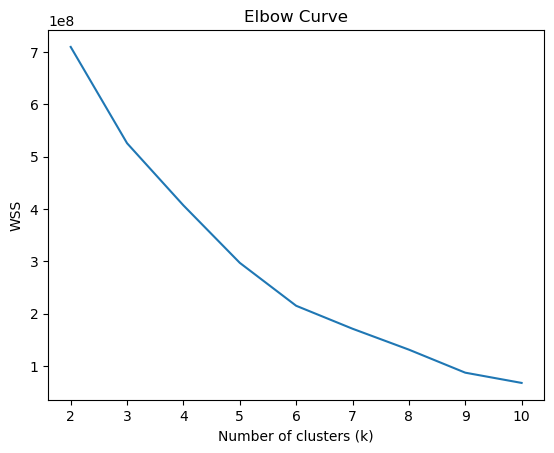

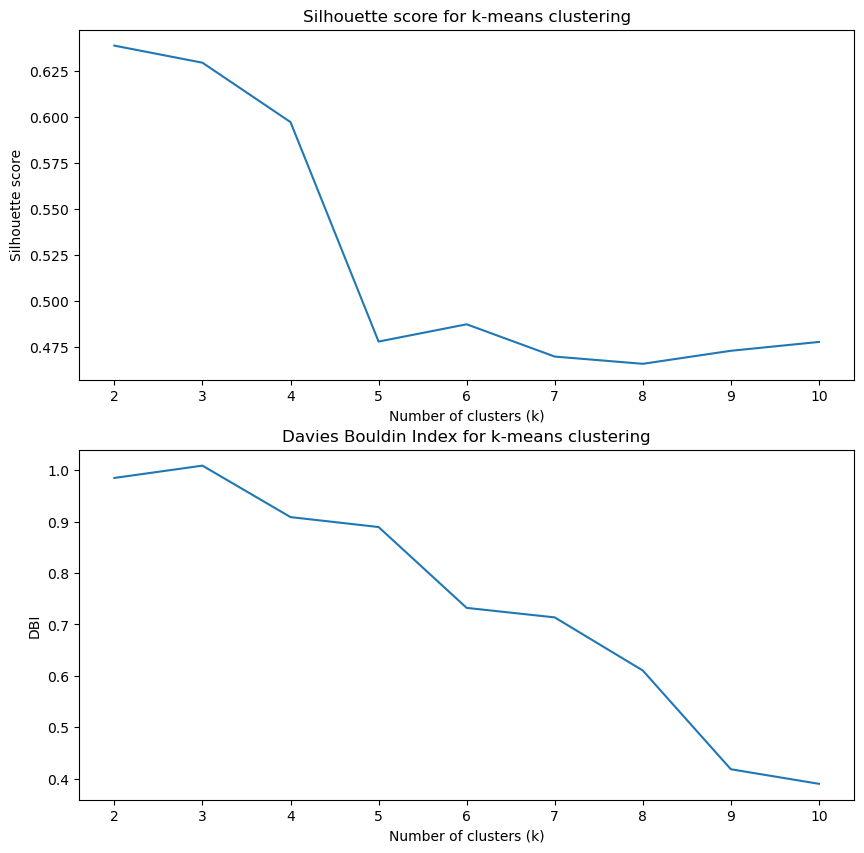

weekend spring


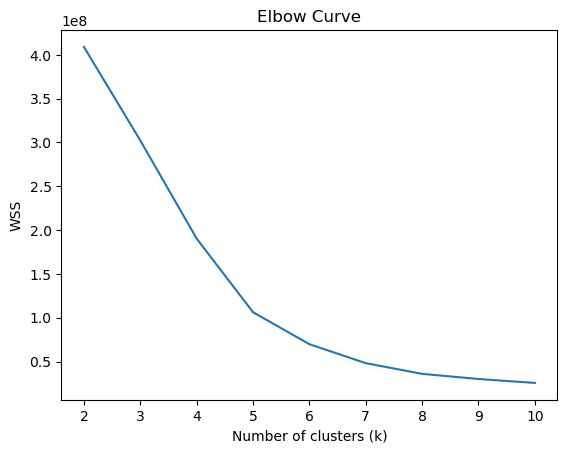

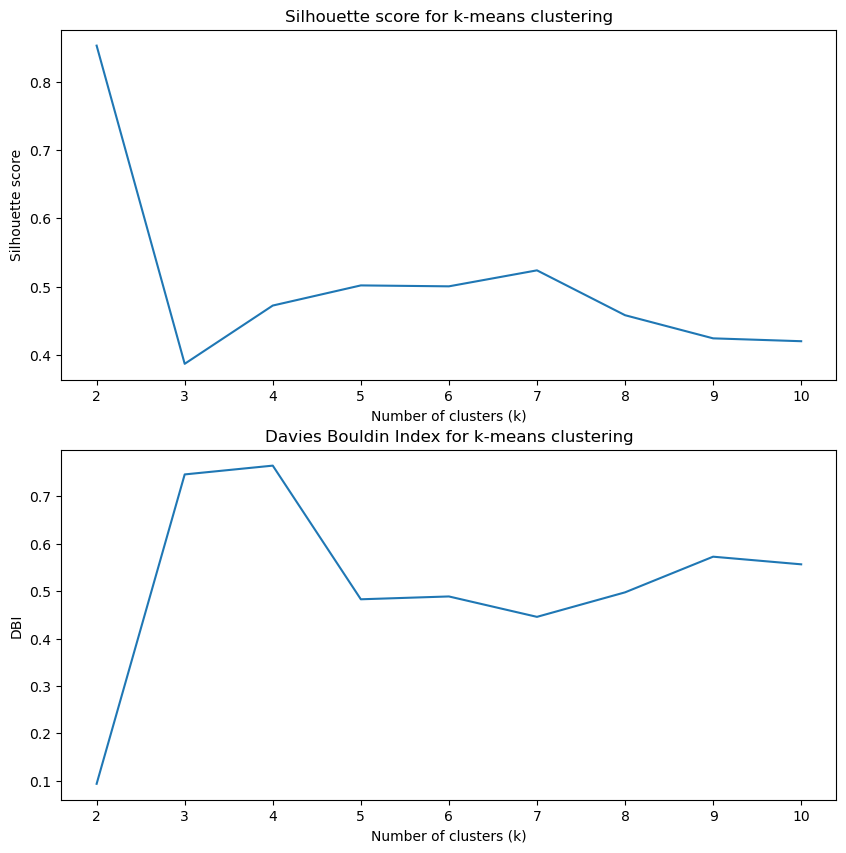

week summer


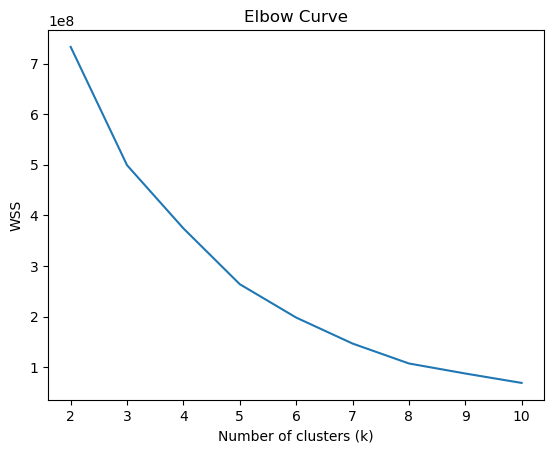

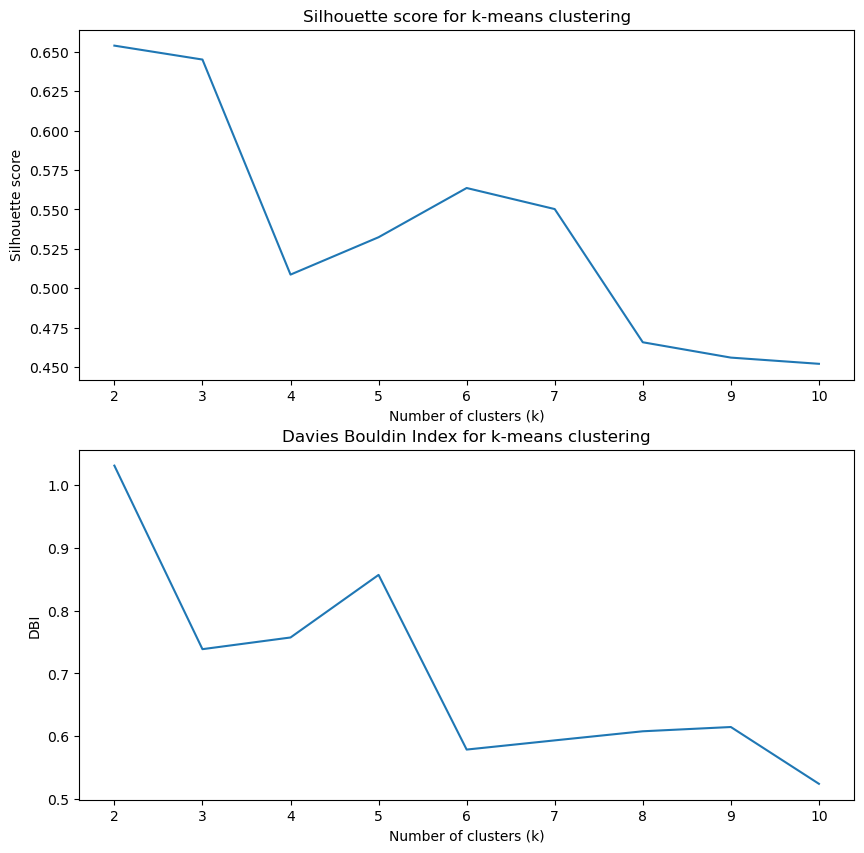

weekend summer


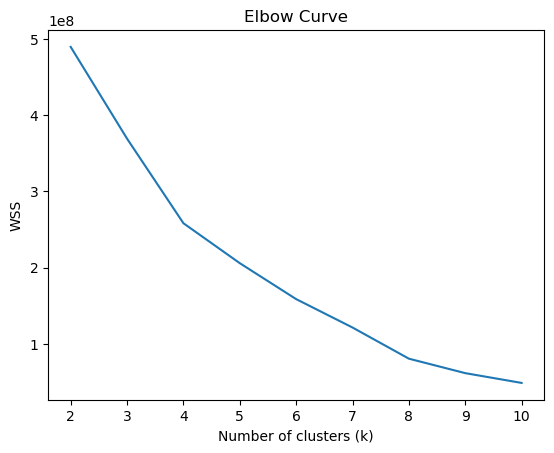

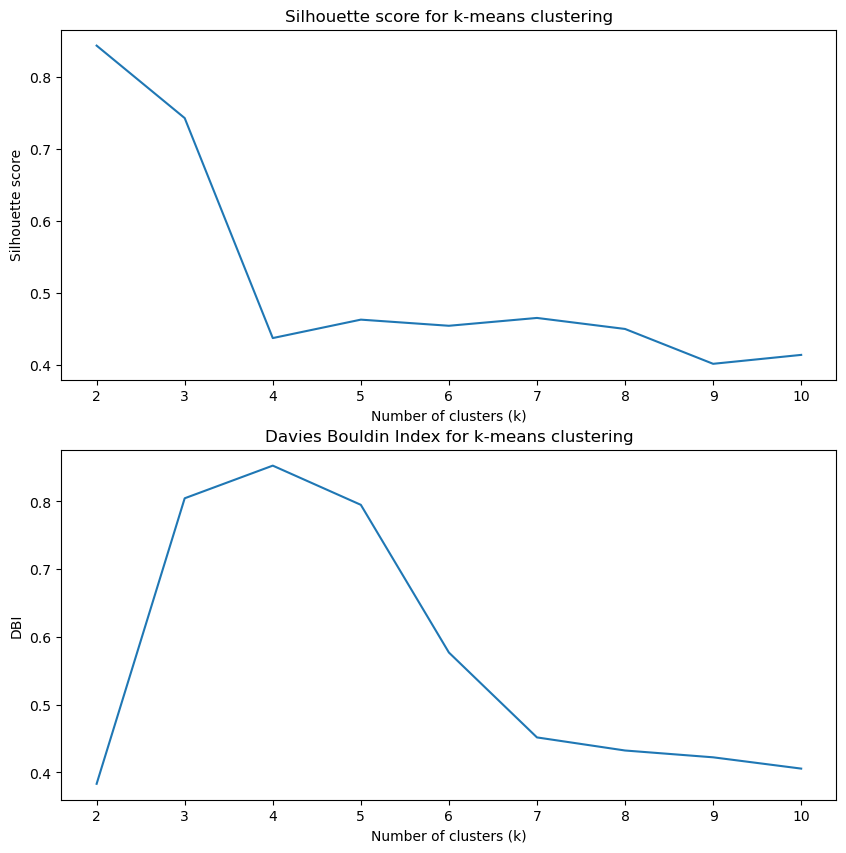

week fall


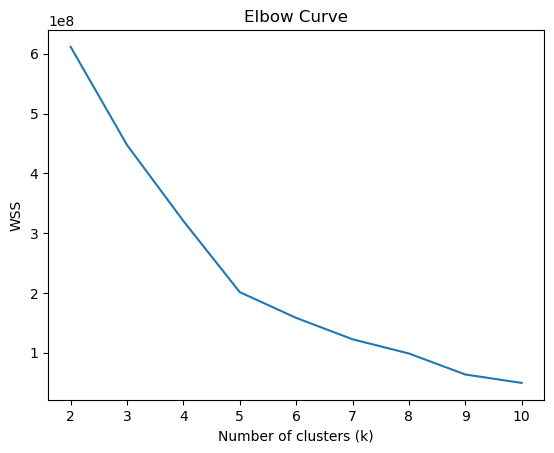

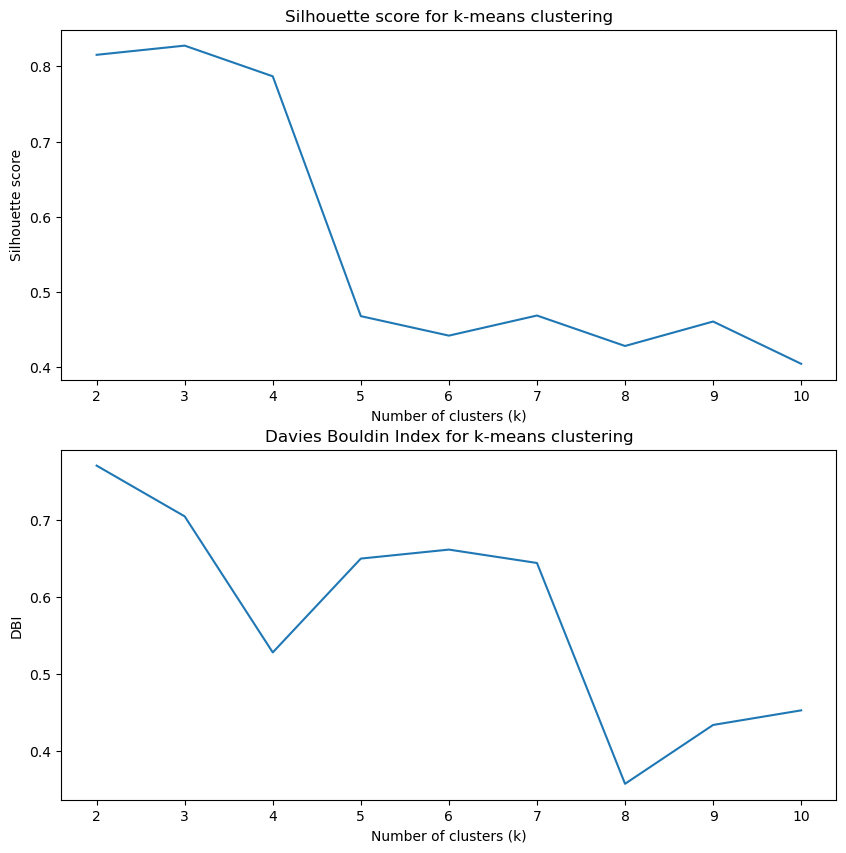

weekend fall


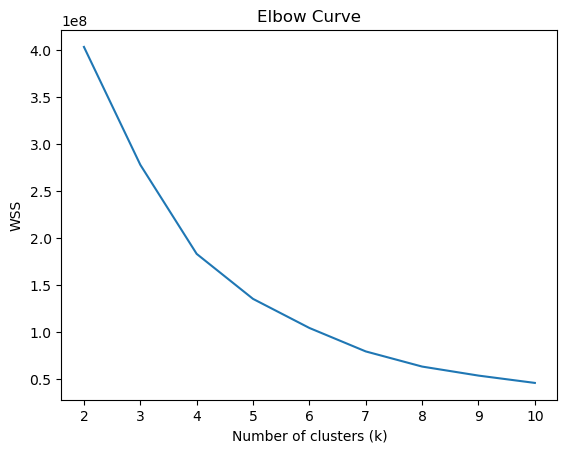

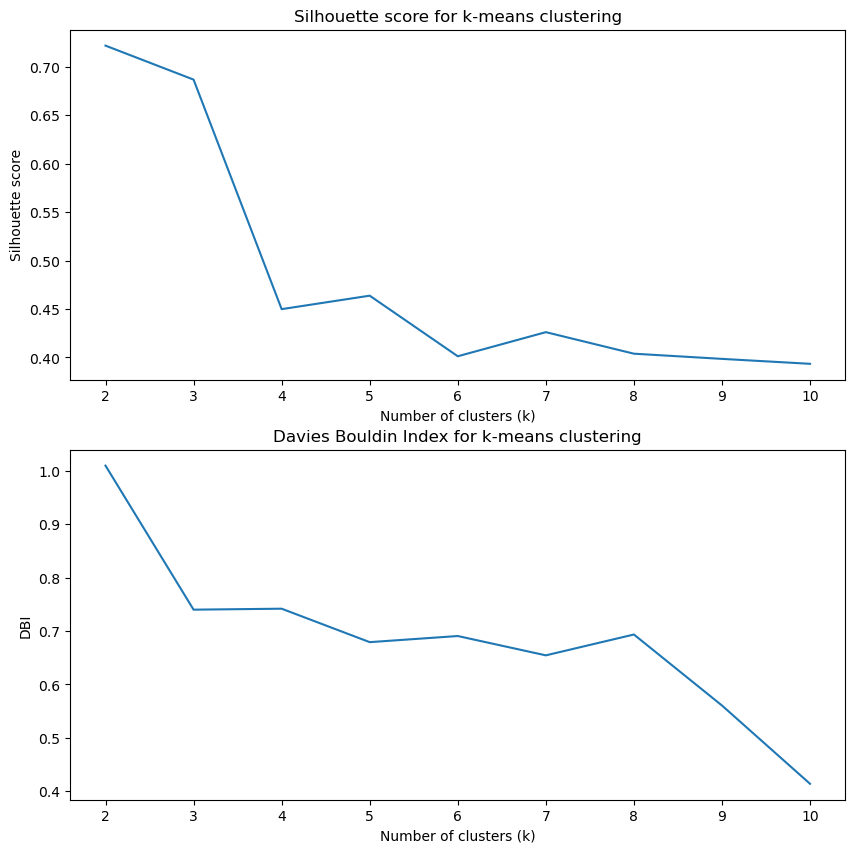

week winter


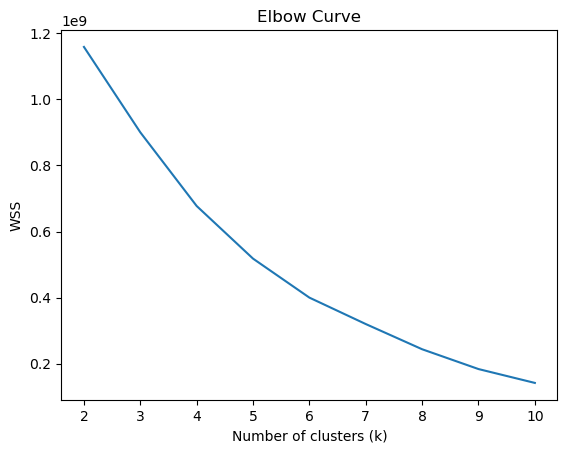

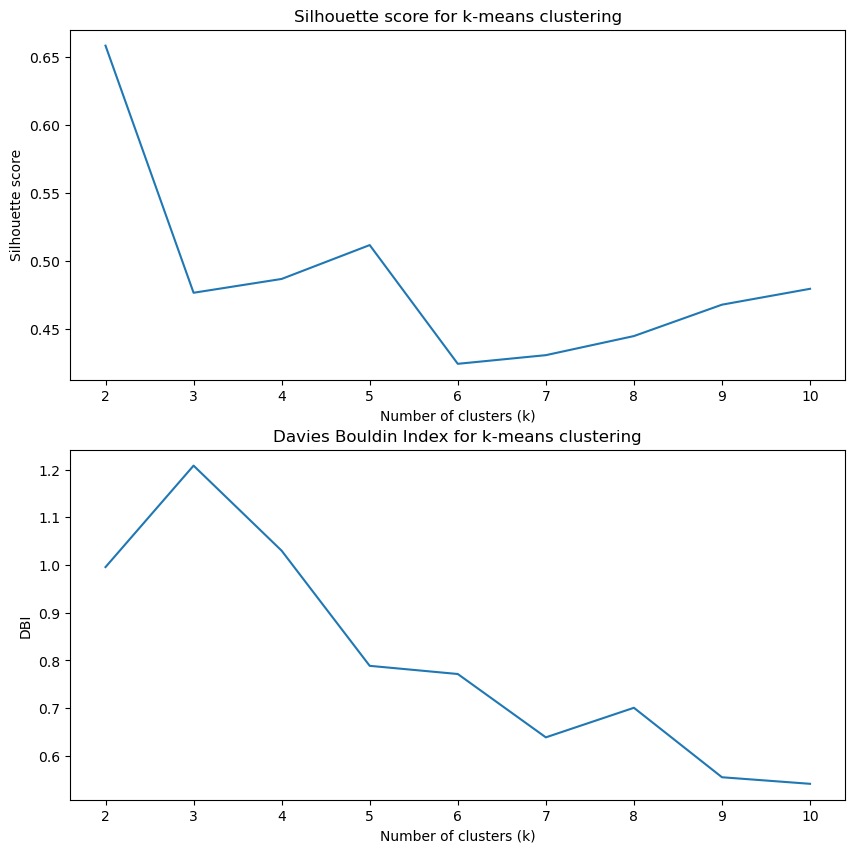

weekend winter


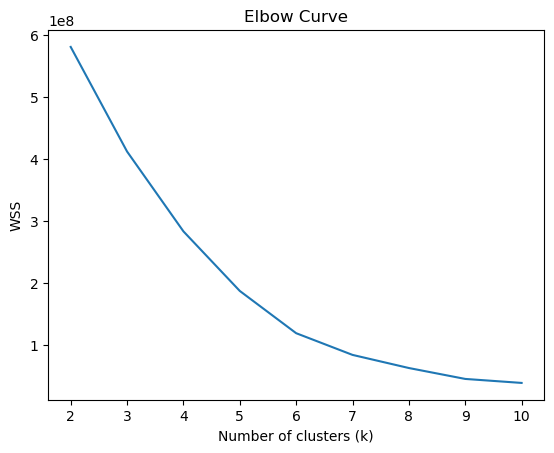

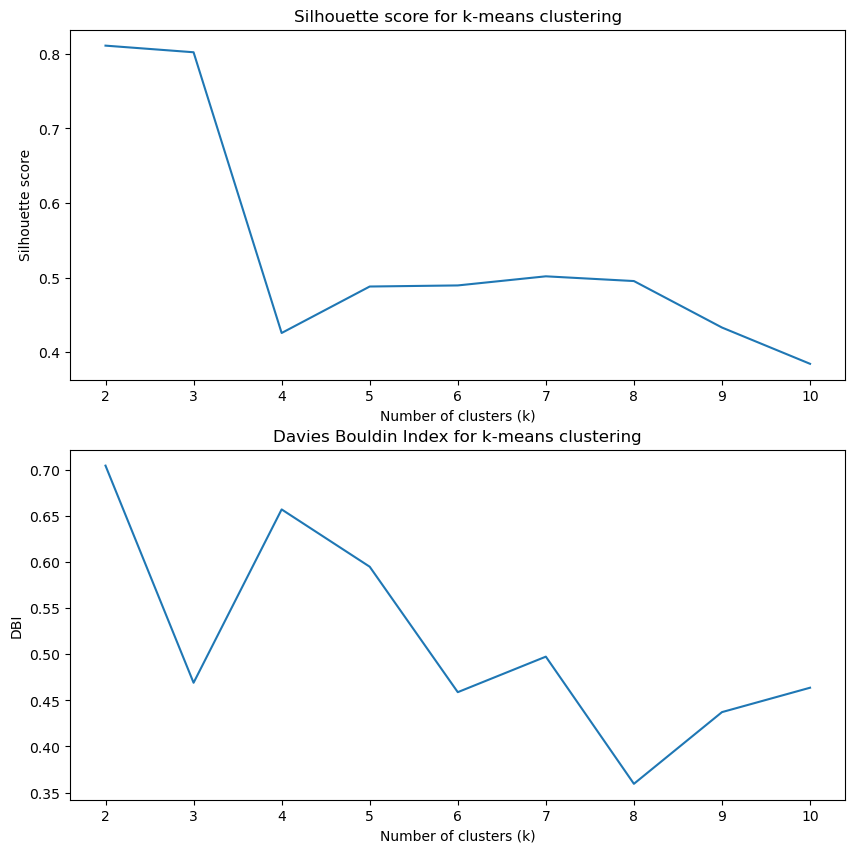

In [48]:
kmeans_dict = df_dict.copy()
kmeans_results = {}
kmeans_cluster_centers = {}
for feature_set in [False]:
    count = 0
    kmeans_results[feature_set] = {}
    kmeans_cluster_centers[feature_set] = {}
    for k,v in kmeans_dict:
        print(k,v)
        kmeans_dict[k,v], kmeans_results[feature_set][k,v] = k_means(df_dict[k,v], active_only = feature_set)



In [ ]:
# Write to csv
for k,v in kmeans_dict:
    to_write = kmeans_dict[k,v].loc[:, kmeans_dict[k,v].columns.str.contains('cluster|substation')]
    to_write.to_csv(f'cluster_assignments/' + str(k) + '_' + str(v) + '_kmeans_cluster.csv')

### <font color = 'lightgreen'> Get list of the cluster centers for the optimal k for a particular time/week combo <font>

<font color ='lightgreen'> Get feature statistics by cluster </font>

In [64]:
# Create a dictionary to hold the relevant values of the features for each cluster for each season/time of week combo
df_stats_numeric = {}
df_stats_string = {}

# Choose k to work with 
k = 5

# Loop through df_dict 
for key in df_dict:
        
    # Group by chosen cluster number
    df_grouped = df_dict[key].groupby(f'cluster_{k}')
    
    # Calculate the mean of each feature for each cluster for all columns that have Active Power and Reactive Power in them
    df_mean = df_grouped.agg('mean')
    
    df_mode = df_grouped.agg(pd.Series.mode)
    
    # Save stats to dictionary
    df_stats_numeric[key] = df_mean
    df_stats_string[key] = df_mode
    
    # Write to csv (first filtering out the unwated columns)
    df_mean_to_write = round(df_mean.loc[:,~df_mean.columns.str.contains('cluster')],2)
    df_mean_to_write.to_csv(f'example_feature_sets/cluster_{k}_numeric_vals_{key[0]}_{key[1]}.csv')
    
    df_mode_to_write = round(df_mode.loc[:,~df_mode.columns.str.contains('cluster')],2)
    df_mode_to_write = df_mode.loc[:,~df_mode.columns.str.contains('substation')] 
    df_mode_to_write = df_mode.loc[:,~df_mode.columns.str.contains('Percent')] 
    df_mode_to_write.to_csv(f'example_feature_sets/cluster_{k}_string_vals_{key[0]}_{key[1]}.csv')
    




/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_5380/857201567.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_mean = df_grouped.agg('mean')
/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_5380/857201567.py:17: FutureWarning: ['Mean value of daily load pattern (kW) Active Power [kW]', 'SD of daily load pattern (kW) Active Power [kW]', 'Max power consumption during a day (kW) Active Power [kW]', 'Min power consumption during a day (kW) Active Power [kW]', 'Range of power consumption during a day (max - min) (kW) Active Power [kW]', 'Percent values above mean val (%) Active Power [kW]', 'Sum of net loads during business hours (9am-6pm) Active Power [kW]', 'Sum of net loads during non-business hours Active Power [kW]', 'Skewness of the distribution of a daily load patte

<font color ='lightgreen'> Get representative sample from each cluster <font>

In [60]:
# Go thru all the season and time of week dataset combos
# In each one, Filter the dataset down to each cluster one at a time (range(1,num_clust+1))
# Pick a random substation from each cluster

num_clust = 5

# Initialize dictionary to hold the filtered dataframes
representative_substations = {}

for k,v in df_dict: 
    representative_substations[k,v] = {}
    cluster_reps = []
    for cluster in range(0,num_clust):
        # Filter down to the cluster
        df = df_dict[k,v].loc[df_dict[k,v][f'cluster_{num_clust}'] == cluster]
        # Pick a random substation
        substation = df.sample(1)['substation'].values[0]
        # Filter down to the substation
        #this_cluster_rep = df.loc[df['substation'] == substation]
        # Append to the list of cluster reps (appends in order of cluster number)
        cluster_reps.append(substation)
    print(cluster_reps)
    
    
    
        # Save the df to a dictionary
    representative_substations[k,v] = cluster_reps
        # Save the df to a csv
      #  df.to_csv(f'example_feature_sets/cluster_{num_clust}_substation_{substation}_{k}_{v}.csv')
    

['osney mead pylon ', 'Barry Avenue', 'banjo road tx1 ', 'hempton road gm', 'windmill st deddington']
['chepstow drive', 'Morris house (barns road)', 'Gloucester Green', 'Tappins Coaches', 'Paradise Street RMU B']
['units 1314 Oxford science pk', 'Dan Read Parade', 'southern by pass', 'Tappins Coaches', 'devereaux place ']
['henry road T2', 'Thames view Road no2', 'Gloucester Green', 'Hillsborough Close', 'Bridge View Watlington Road']
['hopcraft lane', 'Gloucester lane tx 1', 'Osney local', 'southern by pass', 'church road fieldside']
['Paradise Street RMU B', 'george more close', 'ashmolean museum pillar', 'Bridge View Watlington Road', 'Hockmore Street']
['The Grove Deddington', 'Paradise Street RMU B', 'windmill st deddington', 'Thames View Road', 'priory rd 1']
['units 1314 Oxford science pk', 'Paradise Street RMU B', 'Ferry hinksey road', 'kingfisher way ss', 'Tappins Coaches']


In [54]:
representative_substations['weekend','summer'], representative_substations['week', 'winter']

(['ashmolean museum ',
  'Thames view Road no2',
  'quintan avenue ',
  'Hillsborough Close'],
 ['Fiennes Road', 'Hillsborough Close', 'newman road', 'priory rd 1'])

Get the median load profiles (or example load profile) for the representative substations
<font color = 'orange'> with error bars <font>

('weekend', 'summer')
0 henry road T2


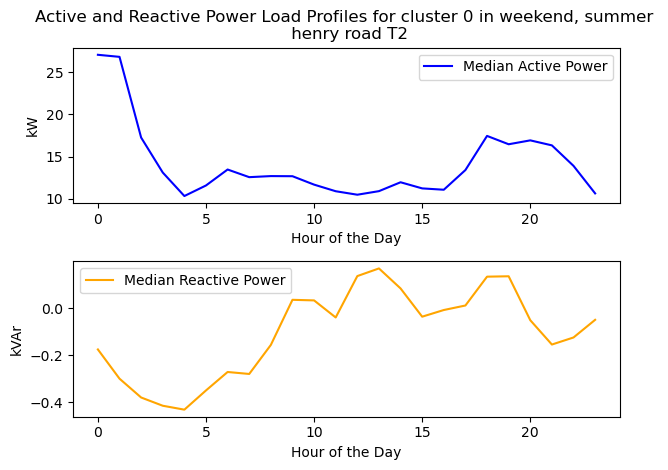

1 Thames view Road no2


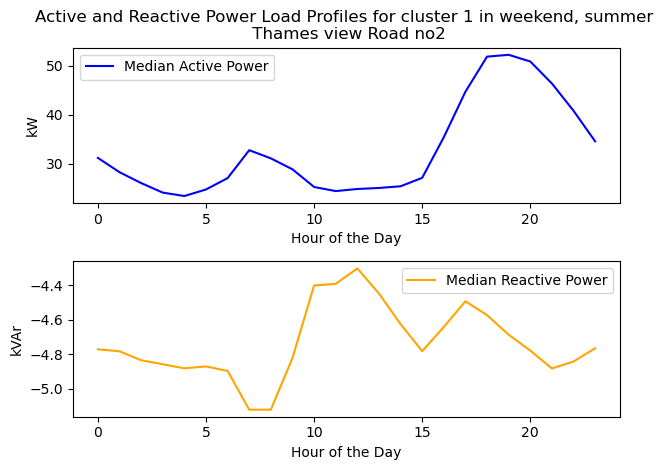

2 Gloucester Green


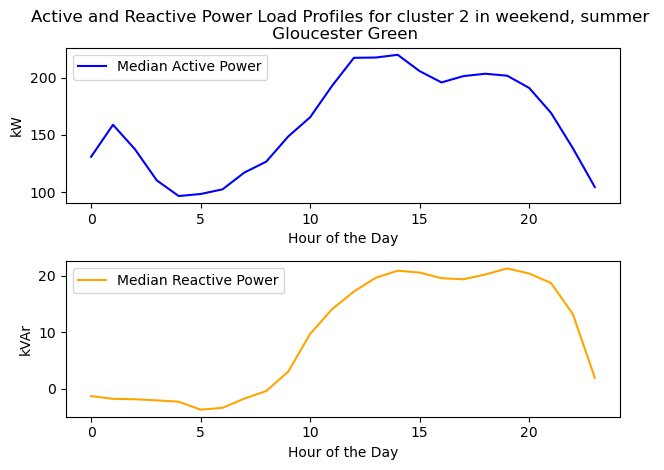

3 Hillsborough Close


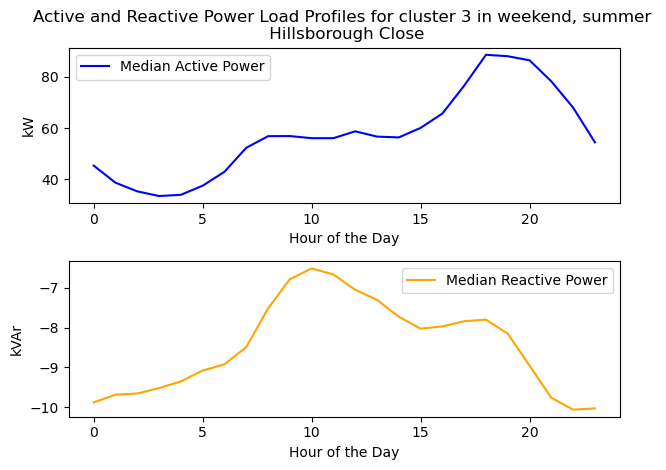

4 Bridge View Watlington Road


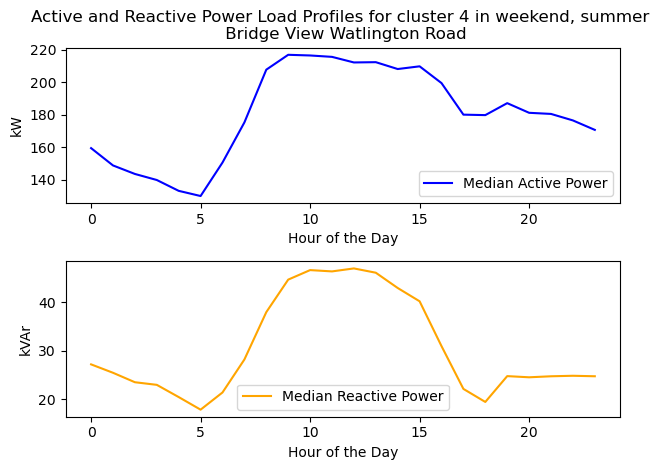

('week', 'winter')
0 The Grove Deddington


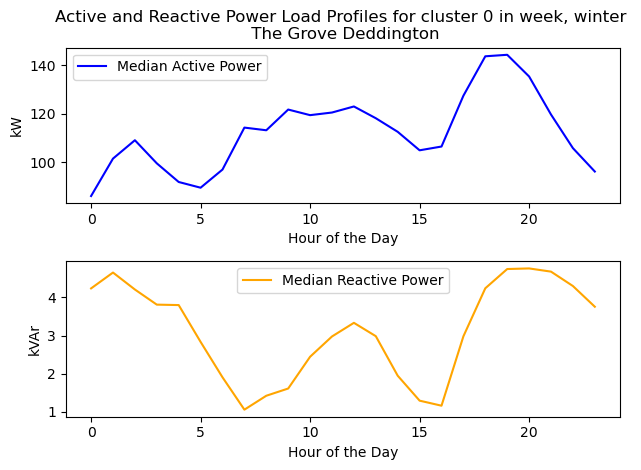

1 Paradise Street RMU B


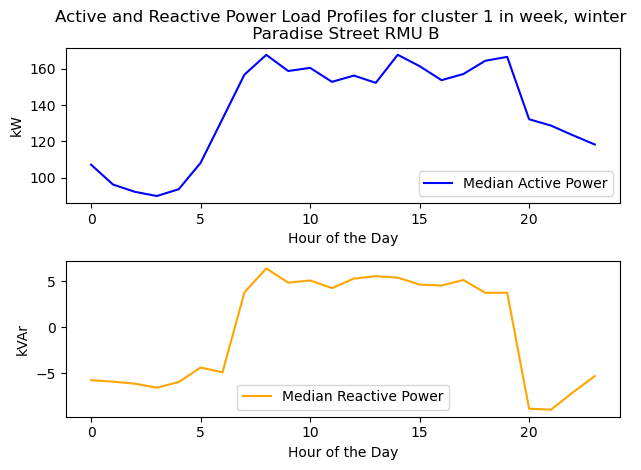

2 windmill st deddington


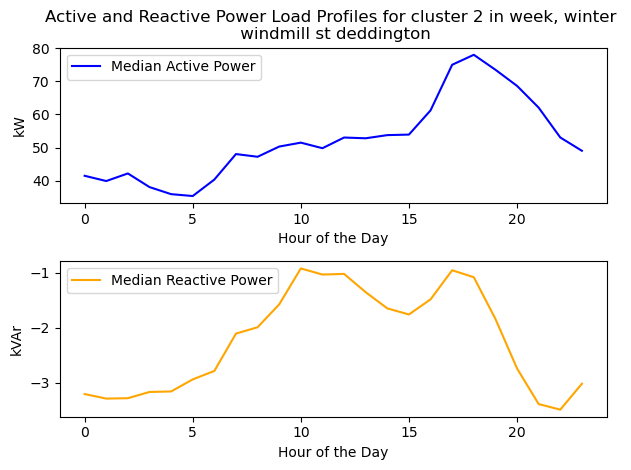

3 Thames View Road


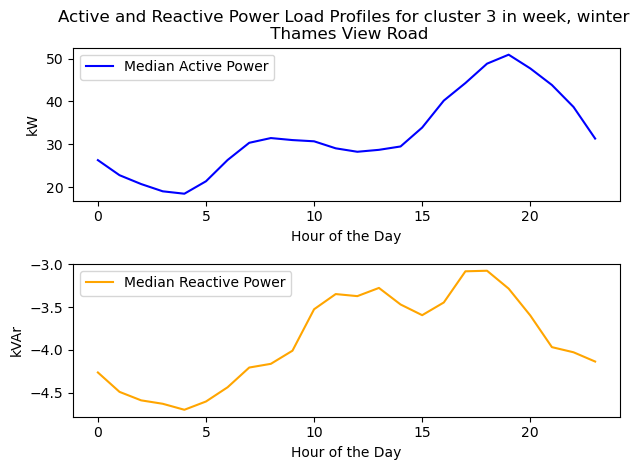

4 priory rd 1


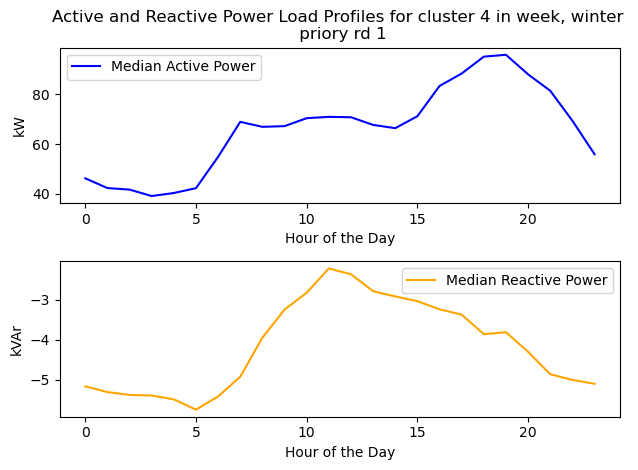

In [62]:
num_clust = 5
for key in representative_substations:
    if key == ('weekend', 'summer') or key == ('week', 'winter'):
        print(key)
        cluster_reps = representative_substations[key]
        
        for cluster_number, substation in enumerate(cluster_reps):
            print(cluster_number, substation)
            dataframes[substation]['Hour'] = dataframes[substation].Datetime.dt.hour
            fig, ax = plt.subplots(2)
            # Main trendlines
            ax[0].plot(dataframes[substation].groupby('Hour').agg('Active Power [kW]').median(), color = 'blue')
          #  ax[0].plot(dataframes[substation].groupby('Hour').agg('Active Power [kW]').mean(), color = 'blue')
            ax[1].plot(dataframes[substation].groupby('Hour').agg('Reactive Power [kVAr]').median(), color = 'orange')
          #  ax[1].plot(dataframes[substation].groupby('Hour').agg('Reactive Power [kVAr]').mean(), color = 'green')
            
            # Error bars
            # ax[0].plot(dataframes[substation].groupby('Hour').agg('Active Power [kW]').max(), color = 'black', linestyle = 'dashed', alpha = 0.5)
            # ax[0].plot(dataframes[substation].groupby('Hour').agg('Active Power [kW]').min(), color = 'black', linestyle = 'dashed', alpha = 0.5)
            # ax[1].plot(dataframes[substation].groupby('Hour').agg('Reactive Power [kVAr]').max(), color = 'black', linestyle = 'dashed', alpha = 0.5)
            # ax[1].plot(dataframes[substation].groupby('Hour').agg('Reactive Power [kVAr]').min(), color = 'black', linestyle = 'dashed', alpha = 0.5)
            
            # Title and Legend
            ax[0].set_title(f'Active and Reactive Power Load Profiles for cluster {cluster_number} in {key[0]}, {key[1]} \n {substation}')
            ax[0].legend(labels= ['Median Active Power', 'Mean Active Power'])
            ax[1].legend(labels= ['Median Reactive Power', 'Mean Reactive Power'])
            
            # Axis labels
            ax[0].set_xlabel('Hour of the Day')
            ax[0].set_ylabel('kW')
            ax[1].set_xlabel('Hour of the Day')
            ax[1].set_ylabel('kVAr')
            
            # Save figure
            os.makedirs(f'example_load_profiles/{key[0]}_{key[1]}', exist_ok = True)
            plt.tight_layout()
            plt.savefig(f'example_load_profiles/{key[0]}_{key[1]}/rep_ss_load_for_{cluster_number}_(out_of_{num_clust}_clusters).png')
            plt.show()
            
    
        
        
        
##### PSEUDO CODE #####
# Go to the representative substation for each cluster and look at the time series data for that substation, from the 'dataframes' dictionary
# Then get the average value of active power in each hour of the day for that substation
# Plot that... 
        

<font color = 'orange'> Considering a specific number of clusters, show the extracted features for the representative substation in each cluster <font>

### <font color = 'orange'> Analyze Clustering Results <font>

Optimal K for each based on elbow method:

Just active power

_Spring_
week: 4, 5 
weekend: 3,4,5

_Summer_
week: 4,5,6
weekend: 3,4,5

_Fall_
week: 3,4,5
weekend: 3,4,5

_Winter_
week: 3,4,5,6
weekend: 3,4,5


Active and reactive power

_Spring_
week: 3,5
weekend: 4,6

_Summer_
week: 4,6
weekend: 3,4,5

_Fall_
week: 3,4,5
weekend: 2,5

_Winter_
week: 4,6,7
weekend: 3,4

## <font color = 'red' > Fuzzy C- Means (not needed) <font>

In [ ]:
import numpy as np
import skfuzzy as fuzz

def fuzzy_c_means(df, c_values = range(2,11), active_only = False, m=2.0, error=0.005, maxiter=1000):
    if active_only:
        # Get the feature set - only active power features
        X = df.loc[:, df.columns.str.contains('Active Power')].values
    else:
        # Get the feature set - all features
        X = df.loc[:, df.columns != 'substation'].values

    # Create an empty dict to hold cluster assignments for each c value
    results = {}

    # Loop through each value of c
    for c in c_values:
        # Apply fuzzy c-means clustering to the feature set
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(X.T, c, m, error=error, maxiter=maxiter, init=None)
        # Calculate the cluster labels based on the maximum degree of membership
        labels = np.argmax(u, axis=0)
        # Assign cluster labels to substations
        df['cluster_{}'.format(c)] = labels
        # Save clustering results
        results[c] = labels
    
    return df, results

def fuzzy_c_means(df, c_values=range(2, 11), active_only=False, m=2, error=0.005, maxiter=1000):
    if active_only:
        X = df.loc[:, df.columns.str.contains('Active Power')].values
    else:
        X = df.loc[:, df.columns != 'substation'].values
    
    X = X.astype(float)  # Convert X to float dtype
    
    results = {}
    for c in c_values:
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(X.T, c, m, error=error, maxiter=maxiter, init=None)
        labels = np.argmax(u, axis=0)
        df['cluster_{}'.format(c)] = labels
        results[c] = labels
        
    return df, results



In [ ]:
cmeans_results = {}
for feature_set in [True, False]:
    count = 0
    cmeans_results[feature_set] = {}
    for k,v in df_dict:
        df_dict[k,v], cmeans_results[feature_set][k,v] = fuzzy_c_means(df_dict[k,v], active_only = feature_set)
    

## <font color = 'lightgreen'> GMM Clustering <Font>

In [ ]:
from sklearn.mixture import GaussianMixture

def gmm_clustering(df, n_components_range=range(1, 11), active_only=False):
    
    if active_only:
        # Get the feature set - only active power features
        X = df.loc[:, df.columns.str.contains('Active Power')].values
    else:
        # Get the feature set - all features
        X = df.loc[:, df.columns != 'substation'].values

    # Create an empty list to hold the BIC scores
    bic_scores = []
    
    # Create empty dict to hold results
    results = {}
    
    # Loop through each value of n_components
    for n_components in n_components_range:
        # Fit the GMM model to the feature set
        gmm = GaussianMixture(n_components=n_components, random_state=42)
        gmm.fit(X)
        # Calculate the BIC for the clustering
        bic_scores.append(gmm.bic(X))
        
        # Save clustering results
        results[n_components] = gmm.predict(X)
        
        # Assign cluster labels to substations
         # Assign cluster labels to substations
        df[f'gmm_cluster_{n_components}'] = gmm.predict(X)
        
    # Plot the BIC scores for each n_components value
    plt.plot(n_components_range, bic_scores)
    plt.xlabel('Number of components')
    plt.ylabel('BIC')
    plt.title('BIC for Gaussian Mixture Models')
    plt.show()
    
    return df, results, bic_scores.index(min(bic_scores)) +1 # +1 because index starts at 0



In [ ]:
gmm_results = {}
bic_scores={}
gmm_dict = df_dict.copy()
for feature_set in [True, False]:
    count = 0
    gmm_results[feature_set] = {}
    bic_scores[feature_set]={}
    for k,v in gmm_dict:
        print(k,v)
        gmm_dict[k,v], gmm_results[feature_set][k,v], bic_scores[feature_set][k,v] = gmm_clustering(df_dict[k,v], active_only = feature_set)
    


In [ ]:
gmm_dict[k,v]

In [ ]:
feature_set = True
for k,v in results[feature_set]:
    print(k,v )
    print(optimal_bic)
    optimal_bic = bic_scores[feature_set][k,v]
    this_df=  pd.DataFrame(gmm_dict[k,v])
    this_df = this_df.loc[:, this_df.columns.str.contains(f'gmm_cluster_{optimal_bic}|substation')]
    this_df.to_csv(f'gmm_results/{k}_{v}_gmm.csv', index=False)
    
  #  pd.DataFrame(results[feature_set][k,v][optimal_bic]).to_csv(f'gmm_results/{k}_{v}_gmm.csv', index=False)
    
    

## <font color='white'> Results </font>

### <font color = 'orange'> Following https://reader.elsevier.com/reader/sd/pii/S0378779619301993?token=5FAC54D7A6CA6790BEC7580137A4522FCA7111B46B1DD72577956217757743B81C723D768184FB895C91D11C7B83E9B9&originRegion=eu-west-1&originCreation=20230221170442 <font>

Cluster substations (e.g. k = 3 as detrmined by dbi), then plot the centroid patterns and the distribution of loads around them (i.e. Fig 6 in the paper) to check if the clusterrs mke sense

### <font color = 'orange'> Following https://reader.elsevier.com/reader/sd/pii/S2210670721006533?token=C94DBE9E60982E7F2BF69C1E92E0F2A14398D874B711E87DD5E17BE10DC975D570A63352F06692BB73F5FF6BAF41F582&originRegion=eu-west-1&originCreation=20230221170713 <font>

Cluster substations (e.g. k = 3 as detrmined by dbi), then plot the centroid patterns and the distribution of loads around them (i.e. Fig 6 in the paper) to check if the clusterrs mke sense

Understanding cluster results

Optimal K for each based on elbow method:

Just active power

_Spring_ <br>
week: 4, 5 
weekend: 3,4,5

_Summer_ <br>
week: 4,5,6
weekend: 3,4,5

_Fall_ <br>
week: 3,4,5
weekend: 3,4,5

_Winter_ <br>
week: 3,4,5,6
weekend: 3,4,5


Active and reactive power

_Spring_ <br>
week: 3,5
weekend: 4,6

_Summer_ <br>
week: 4,6
weekend: 3,4,5

_Fall_ <br>
week: 3,4,5
weekend: 2,5

_Winter_ <br>
week: 4,6,7
weekend: 3,4

In [ ]:
for k,v in results[True]:
    print(k,v, results[True][k,v])

In [ ]:
for k,v in results[True]:
    cluster_assignments = results[True][k,v]
    df = pd.DataFrame(cluster_assignments)
    df.to_csv(f'cluster_assignments/{k}_{v}.csv')
#     for num_clust, labels in cluster_assignments.items():
#         # Create dataframe where each column has the cluster assignments for each k value 
#         df[f'cluster_{num_clust}'] = labels
        
#         df = pd.DataFrame(labels, columns = ['labels']).sort_values(by ='labels')


# df.to_csv(f'cluster_assignments/{k}_{v}_numclust=_{num_clust}.csv')
#        # cluster_assignments.sort_values(by=['cluster_6']).to_csv(f'cluster_assignments/{k}_{v}.csv')
    

In [ ]:
#k = 5
for k,v in df_dict:
    print(k,v)
  #  df_dict[k,v][]
    cluster_assignments = df_dict[k,v][['substation', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10']]
   # print(np.array(cluster_assignments.sort_values(by=['cluster_6'])))
  #  cluster_assignments.sort_values(by=['cluster_6']).to_csv(f'cluster_assignments/{k}_{v}.csv')
    cluster_assignments.to_csv(f'cluster_assignments/{k}_{v}.csv')
    
    


## <font color = 'pink'> pk prd features (not used) </font>

Peak period features </br>

No. of peak periods  </br>
Occurrence time (starting time) of each peak period </br>
Shortest time interval between peaks if more than one peak exists  </br>
Duration of each peak  </br>
Occurrence time of longest peak period  </br>
Duration longest peak period  </br>
Upward slope of longest peak  </br>
Downward slope of the longest peak

In [ ]:

def find_peak_period_features(data, alphabet_size=3, window_size=30, threshold=0.2):
    """
    Identifies peak period features in a time series using Symbolic Aggregate Approximation (SAX).
    
    Parameters:
        - data: a list or numpy array containing the time series data
        - alphabet_size: the number of symbols to use in the SAX representation (default is 3)
        - window_size: the size of the sliding window to use (default is 30)
        - threshold: the threshold value used to identify peak periods (default is 0.2)
    
    Returns:
        - A list of tuples, where each tuple contains the start and end index of a peak period.
    """
    
    sax = SAX(wordSize=window_size//alphabet_size, alphabetSize=alphabet_size) # Initialize the SAX object
    
    # Transform the time series data into a SAX representation
    sax_data = sax.to_letter_rep(data)
    
    # Compute the frequencies of each symbol in the SAX representation
    freqs = [sax_data.count(sym) / len(sax_data) for sym in sax.get_symbols()]
    
    # Find the threshold value for identifying peak periods
    mean_freq = sum(freqs) / len(freqs)
    std_dev_freq = (sum((f - mean_freq)**2 for f in freqs) / len(freqs))**0.5
    peak_threshold = mean_freq + std_dev_freq * threshold
    
    # Find the indices of the start and end of each peak period
    peak_periods = []
    in_peak_period = False
    for i in range(len(sax_data)):
        if freqs[sax_data[i]] >= peak_threshold:
            if not in_peak_period:
                peak_start = i
                in_peak_period = True
        else:
            if in_peak_period:
                peak_periods.append((peak_start * window_size, i * window_size))
                in_peak_period = False
    
    if in_peak_period: # Handle the case where a peak period continues to the end of the data
        peak_periods.append((peak_start * window_size, len(data)))
    
    return peak_periods


In [ ]:
from tslearn.piecewise import SymbolicAggregateApproximation
import numpy as np

# Create a random time series
X = np.array(dataframes['76 Church Road']['Active Power [kW]'])

# Define the SAX transformation parameters
n_bins = 4
strategy = 'uniform'
window_size = 20

# Create the SAX object and transform the time series
sax = SymbolicAggregateApproximation(n_segments=5, alphabet_size_avg=n_bins)
X_sax = sax.fit_transform(X.reshape(1, -1))

# Print the transformed time series
print(X_sax)



In [ ]:


def sax(time_series, alphabet_size, n_segments):
    # Helper function to convert the time series into symbolic representations using SAX
    # Returns the symbolic representations
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(time_series.reshape(-1, 1))
    kmeans = KMeans(n_clusters=alphabet_size, random_state=0).fit(scaled_data)
    distances = np.min(cdist(scaled_data, kmeans.cluster_centers_, 'euclidean'), axis=1)
    thresholds = np.percentile(distances, np.linspace(0, 100, alphabet_size + 1)[1:-1])
    symbolic_representation = np.zeros(len(scaled_data))
    for i in range(1, alphabet_size):
        symbolic_representation[distances <= thresholds[i-1]] = i
    symbolic_representation = np.array_split(symbolic_representation, n_segments)
    symbolic_representation = [''.join([str(int(symbol)) for symbol in segment]) for segment in symbolic_representation]
    return symbolic_representation

# First, we need to group the data by day
grouped = substation_df.groupby(by=[substation_df['date'].dt.date])

# Next, we need to iterate through each day to convert the time series into symbolic representations using SAX
peak_periods = []
for date, group in grouped:
    symbolic_representation = sax(group['Active Power [kW]'].values, 5, 24)
    peak_periods.append({
        'date': date,
        'symbolic_representation': symbolic_representation,
    })

# Now we can extract the various peak period features from the symbolic representations
number_of_peak_periods = []
occurrence_time_of_peaks = []
shortest_time_interval_between_peaks = []
duration_of_peaks = []
occurrence_time_of_longest_peak = []
duration_longest_peak = []
for period in peak_periods:
    peaks = [i for i, symbol in enumerate(period['symbolic_representation']) if symbol.count('1') >= 4]
    if peaks:
        number_of_peak_periods.append(len(peaks))
        occurrence_time_of_peaks.append([substation_df[substation_df['date'].dt.date == period['date']].iloc[peak]['date'] for peak in peaks])
        shortest_time_interval_between_peaks.append(min
####

    shortest_interval = None
    for i in range(1, len(peaks)):
        interval = peaks[i] - peaks[i-1]
        if shortest_interval is None or interval < shortest_interval:
            shortest_interval = interval
    shortest_time_interval_between_peaks.append(shortest_interval)

    peak_durations = []
    for peak in peaks:
        start = peak
        end = peak
        while end < len(period['symbolic_representation']) - 1 and period['symbolic_representation'][end + 1] == '1':
            end += 1
        peak_durations.append(end - start + 1)
    duration_of_peaks.append(peak_durations)

    longest_peak_duration = 0
    longest_peak_occurrence = None
    for i, duration in enumerate(peak_durations):
        if duration > longest_peak_duration:
            longest_peak_duration = duration
            longest_peak_occurrence = occurrence_time_of_peaks[-1][i]
    occurrence_time_of_longest_peak.append(longest_peak_occurrence)
    duration_longest_peak.append(longest_peak_duration)

# To find the upward and downward slopes of the longest peak, we need to access the original time series data
upward_slope_longest_peak = []
downward_slope_longest_peak = []
for i, period in enumerate(peak_periods):
    date = period['date']
    group = substation_df[substation_df['date'].dt.date == date]
    longest_peak_start = group[group['date'] == occurrence_time_of_longest_peak[i]].index[0]
    longest_peak_end = longest_peak_start + duration_longest_peak[i] - 1
    longest_peak = group[longest_peak_start:longest_peak_end+1]['Active Power [kW]'].values
    upward_slope = (longest_peak[-1] - longest_peak[0]) / duration_longest_peak[i]
    downward_slope = (longest_peak[0] - longest_peak[-1]) / duration_longest_peak[i]
    upward_slope_longest_peak.append(upward_slope)
    downward_slope_longest_peak.append(downward_slope)


In [ ]:
# substation_df = df
# def find_peaks(power_series):
#     # Helper function to find the peaks in a time series
#     # Returns a list of indeces of peak hours, where peak is defined as an hour with higher active power than both the previous and next hour  
#     peaks = []
#     for i in range(1, len(power_series) - 1):
#         if power_series[i] > power_series[i-1] and power_series[i] > power_series[i+1]:
#             peaks.append(i)
#     return peaks

# # Group data by day
# grouped = substation_df.groupby(by=[substation_df['Date']])

# # Next, we need to iterate through each day to find the peak periods
# peak_periods = []
# for date, group in grouped:
#     peaks = find_peaks(group['Active Power [kW]'].values)
#     if peaks:
#         peak_periods.append({
#             'date': date,
#             'peaks': peaks,
#         })

# # Now we can extract the various features for each day
# number_of_peak_periods = [len(period['peaks']) for period in peak_periods]
# occurrence_time_of_peaks = [substation_df.iloc[period['peaks'][0]]['Date'] for period in peak_periods]
# duration_of_peaks = []
# longest_peak_duration = []
# longest_peak_start = []
# longest_peak_end = []
# longest_peak_upward_slope = []
# longest_peak_downward_slope = []
# for period in peak_periods:
#     peaks = period['peaks']
#     date = period['date']
#     peak_durations = [peaks[i+1] - peaks[i] for i in range(len(peaks) - 1)]
#     duration_of_peaks.append(peak_durations)
#     if peak_durations:
#         longest_peak_index = np.argmax(peak_durations)
#         longest_peak_start.append(substation_df.iloc[peaks[longest_peak_index]]['Date'])
#         longest_peak_end.append(substation_df.iloc[peaks[longest_peak_index + 1]]['Date'])
#         longest_peak_duration.append(peak_durations[longest_peak_index])
#         longest_peak_values = group['Active Power [kW]'].iloc[peaks[longest_peak_index]:peaks[longest_peak_index + 1] + 1].values
#         longest_peak_upward_slope.append(np.polyfit(range(len(longest_peak_values)), longest_peak_values, 1)[0])
#         longest_peak_downward_slope.append(np.polyfit(range(len(longest_peak_values[::-1])), longest_peak_values[::-1], 1)[0])
#     else:
#         longest_peak_duration.append(None)
#         longest_peak_start.append(None)
#         longest_peak_end.append(None)
#         longest_peak_upward_slope.append(None)
       




# daily_groups =df.groupby(['Date'])
# peak_hour = daily_groups['Active Power [kW]'].idxmax().map(lambda x: substation_data.loc[x, 'Hour'])
# peak_hour

# <font color='orange'> To-Do: </font>
0. Drop substations with >50% missing data <font color='lightgreen'> done! </font> <br>
0b. Split substation dataframes by season, week, and weekend <font color='lightgreen'> done! </font> </br>
0c. Filter out substations that are missing too many days in each dataframe (determine a threshold) <font color='lightgreen'> done! </font> </br>
1. Extract active power features - separately on all datasets <font color = 'lightgreen'> done! </font> 
2. Clustering on active power features <font color = 'lightgreen'> done! </font>
3. Extract reactive power features <font color = 'lightgreen'> done!  </font>
4. Cluster on active and reactive power features <font color = 'lightgreen'> done!  </font>
5. Download busbar data and repeat analysis <font color = 'orange'> in progress  </font>